## Part 1: Text Preprocessing and Exploration

Let's import the required libraries and load our dataset:

In [ ]:
!pip install nltk

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter

# For text preprocessing
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# For dataset loading
from sklearn.datasets import fetch_20newsgroups

# Set random seed for reproducibility
np.random.seed(42)

# Load a subset of the 20 Newsgroups dataset
categories = ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, random_state=42)

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'text': newsgroups.data,
    'category': [newsgroups.target_names[target] for target in newsgroups.target]
})

# Preview the data
print(f"Dataset shape: {df.shape}")
print("\nCategory distribution:")
print(df['category'].value_counts())
print("\nSample document:")
print(df['text'][10][:500])  # Print first 500 characters of a sample document

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 455.8 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.9 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 kB 2.8 MB/s eta 0:00:0000:0100:01


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Dataset shape: (2236, 2)

Category distribution:
category
rec.autos             594
sci.space             593
comp.graphics         584
talk.politics.misc    465
Name: count, dtype: int64

Sample document:
From: bob1@cos.com (Bob Blackshaw)
Subject: Re: Dumbest Driver Action
Organization: Corporation for Open Systems
Distribution: usa 
Lines: 41

In <C5Dq2n.5uB@news.cso.uiuc.edu> mwbg9715@uxa.cso.uiuc.edu (Mark Wayne Blunier) writes:

>jimf@centerline.com (Jim Frost) writes:

>>I wish I had the figures with me to back me up, but I recall
>>statistics showing that women tended to have more accidents than men
>>but the damage was generally quite minor.  Men had fewer but far more
>>expensive acciden


### Step 1: Basic Data Exploration
Let's examine the length characteristics of our documents:

        text_length   word_count  sentence_count
count   2236.000000  2236.000000     2236.000000
mean    1918.330948   291.903846       16.249553
std     3850.168516   584.403700       32.945190
min      125.000000    15.000000        1.000000
25%      744.000000   104.000000        6.000000
50%     1157.500000   173.500000       10.000000
75%     1859.000000   290.000000       16.000000
max    60713.000000  9168.000000      536.000000


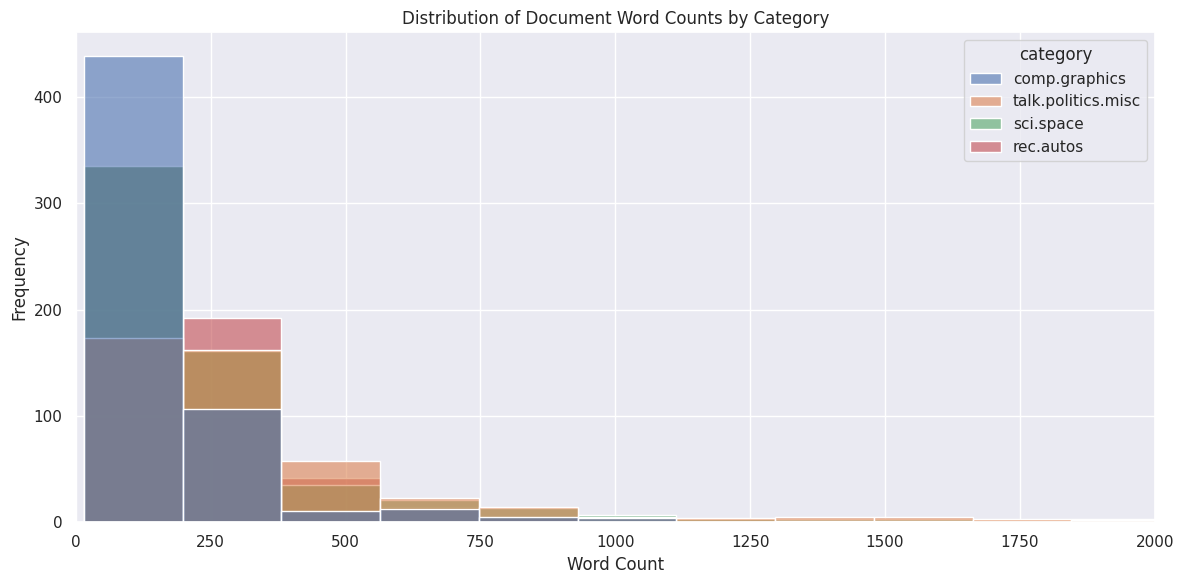

In [47]:
# Calculate text length statistics
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['sentence_count'] = df['text'].apply(lambda x: len(sent_tokenize(x)))

# Display basic statistics
print(df[['text_length', 'word_count', 'sentence_count']].describe())

# Visualize document length distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='category', bins=50, alpha=0.6)
plt.title('Distribution of Document Word Counts by Category')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 2000)  # Focus on the main distribution
plt.tight_layout()
plt.show()

### Step 2: Text Cleaning and Preprocessing Function
Let's create a comprehensive text preprocessing function that incorporates all the techniques we've learned:

In [48]:
def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    """
    Comprehensive text preprocessing function

    Parameters:
    -----------
    text : str
        The input text to preprocess
    remove_stopwords : bool
        Whether to remove stopwords
    lemmatize : bool
        Whether to apply lemmatization (if False, uses stemming instead)

    Returns:
    --------
    list
        List of preprocessed tokens
    """
    # Handle empty or non-string input
    if not isinstance(text, str) or text.strip() == '':
        return []

    # Convert to lowercase
    text = text.lower()

    # Remove email headers (common in newsgroup data)
    text = re.sub(r'^.*?lines:.*?\n\n', '', text, flags=re.DOTALL)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords if requested
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

    # Apply lemmatization or stemming
    if lemmatize:
        # Get POS tags for better lemmatization
        pos_tags = nltk.pos_tag(tokens)

        # Helper function to convert NLTK POS tags to WordNet POS tags
        def get_wordnet_pos(tag):
            tag_first_char = tag[0].upper()
            tag_dict = {
                'J': nltk.corpus.wordnet.ADJ,
                'N': nltk.corpus.wordnet.NOUN,
                'V': nltk.corpus.wordnet.VERB,
                'R': nltk.corpus.wordnet.ADV
            }
            return tag_dict.get(tag_first_char, nltk.corpus.wordnet.NOUN)

        # Lemmatize with POS tag
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos))
                  for word, pos in pos_tags]
    else:
        # Use stemming instead
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    # Remove tokens with less than 3 characters (likely not meaningful)
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

### Step 3: Apply Preprocessing and Analyze Results
Now let's apply our preprocessing function to the dataset and examine the results:

In [49]:
# Apply preprocessing to a sample document for demonstration
sample_idx = 10
sample_doc = df['text'][sample_idx]

print("Original document snippet:")
print(sample_doc[:500])

# Apply different preprocessing configurations
tokens_basic = preprocess_text(sample_doc, remove_stopwords=False, lemmatize=False)
tokens_nostop = preprocess_text(sample_doc, remove_stopwords=True, lemmatize=False)
tokens_lemma = preprocess_text(sample_doc, remove_stopwords=True, lemmatize=True)

print("\nBasic preprocessing (lowercase, no stopword removal, stemming):")
print(tokens_basic[:20])

print("\nWith stopword removal:")
print(tokens_nostop[:20])

print("\nWith lemmatization:")
print(tokens_lemma[:20])

# Apply preprocessing to the entire dataset
df['processed_tokens'] = df['text'].apply(preprocess_text)
df['processed_text'] = df['processed_tokens'].apply(lambda x: ' '.join(x))

# Show a sample of processed text
print("\nSample processed document:")
print(df['processed_text'][sample_idx])

Original document snippet:
From: bob1@cos.com (Bob Blackshaw)
Subject: Re: Dumbest Driver Action
Organization: Corporation for Open Systems
Distribution: usa 
Lines: 41

In <C5Dq2n.5uB@news.cso.uiuc.edu> mwbg9715@uxa.cso.uiuc.edu (Mark Wayne Blunier) writes:

>jimf@centerline.com (Jim Frost) writes:

>>I wish I had the figures with me to back me up, but I recall
>>statistics showing that women tended to have more accidents than men
>>but the damage was generally quite minor.  Men had fewer but far more
>>expensive acciden

Basic preprocessing (lowercase, no stopword removal, stemming):
['cdqnubnewscsouiucedu', 'mwbguxacsouiucedu', 'mark', 'wayn', 'blunier', 'write', 'jimfcenterlinecom', 'jim', 'frost', 'write', 'wish', 'had', 'the', 'figur', 'with', 'back', 'but', 'recal', 'statist', 'show']

With stopword removal:
['cdqnubnewscsouiucedu', 'mwbguxacsouiucedu', 'mark', 'wayn', 'blunier', 'write', 'jimfcenterlinecom', 'jim', 'frost', 'write', 'wish', 'figur', 'back', 'recal', 'statist', 

### Step 4: Token Frequency Analysis
Let's analyze the most common words in each category after preprocessing:

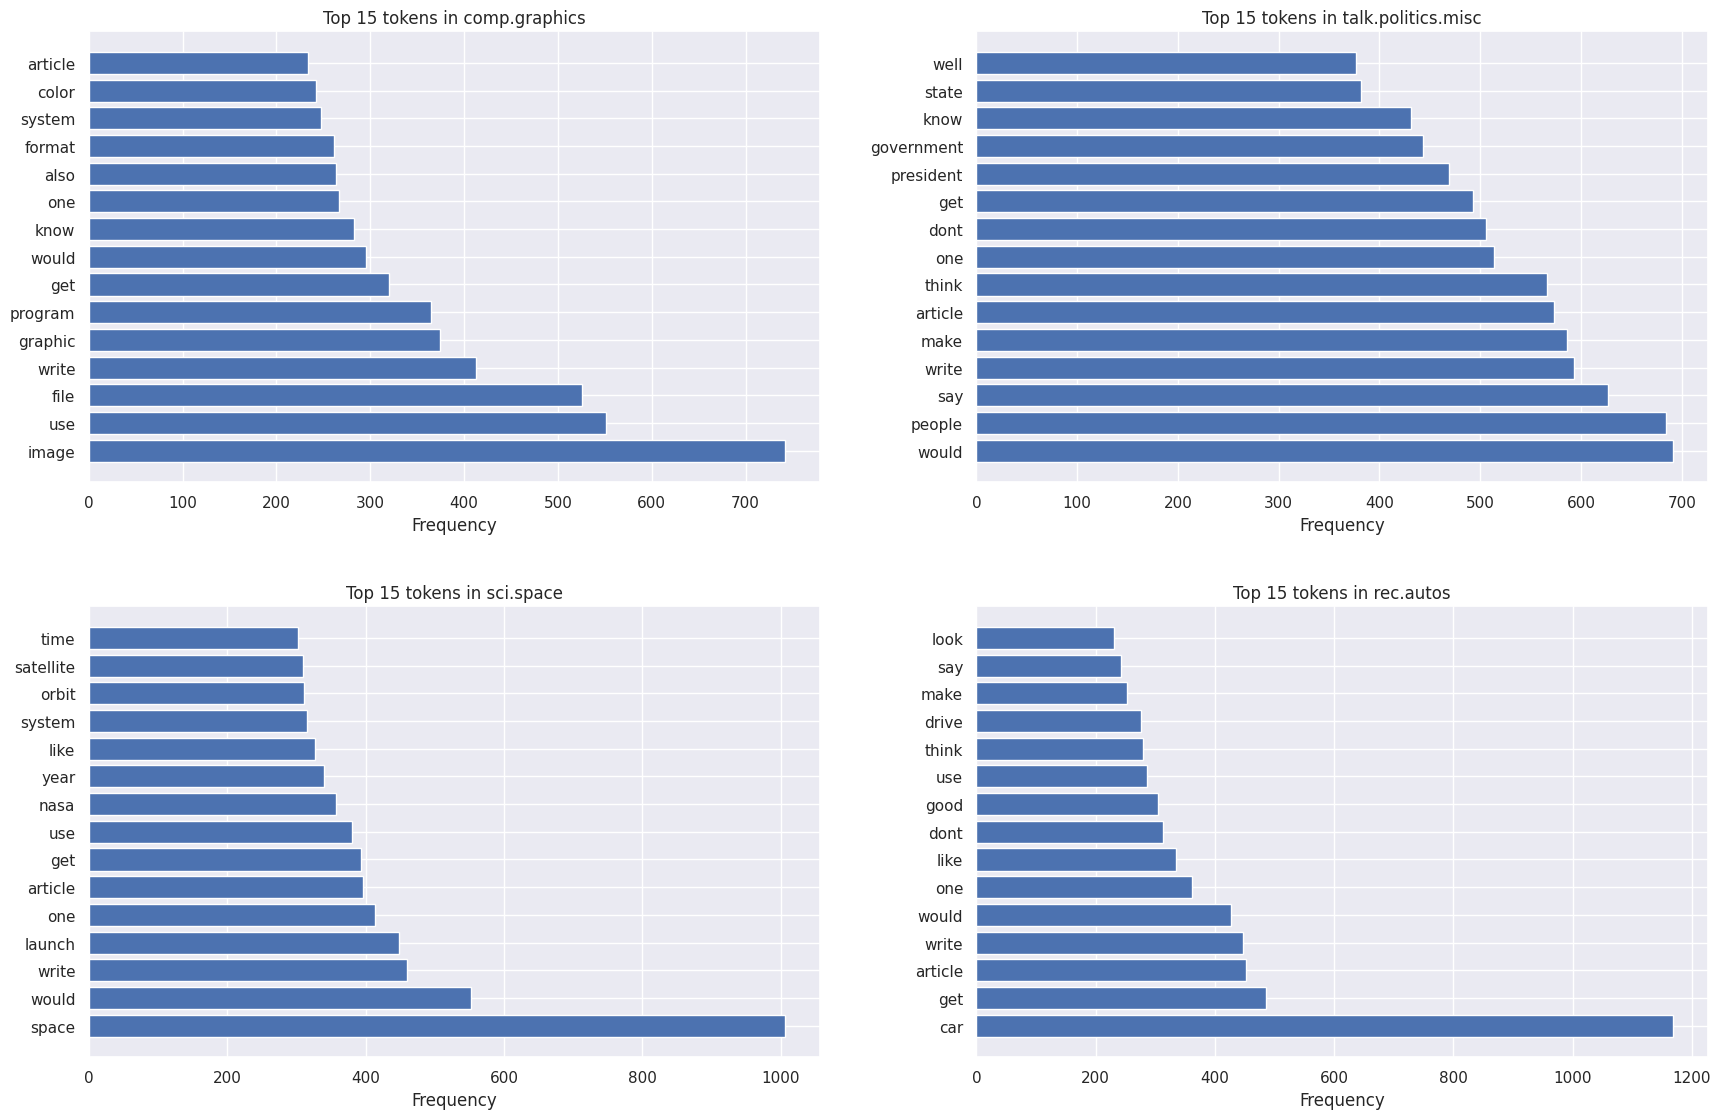

In [50]:
# Function to visualize most common tokens by category
def plot_top_tokens(dataframe, category_col, tokens_col, n=15):
    """Plot the most common tokens for each category"""
    plt.figure(figsize=(18, 12))

    # Get unique categories
    categories = dataframe[category_col].unique()
    num_categories = len(categories)

    # Create subplots
    for i, category in enumerate(categories, 1):
        plt.subplot(2, 2, i)

        # Get all tokens for this category
        category_tokens = []
        for tokens in dataframe[dataframe[category_col] == category][tokens_col]:
            category_tokens.extend(tokens)

        # Count token frequencies
        token_counts = Counter(category_tokens).most_common(n)
        tokens, counts = zip(*token_counts)

        # Create horizontal bar chart
        y_pos = np.arange(len(tokens))
        plt.barh(y_pos, counts, align='center')
        plt.yticks(y_pos, tokens)
        plt.xlabel('Frequency')
        plt.title(f'Top {n} tokens in {category}')
        plt.tight_layout()

    plt.tight_layout(pad=3.0)
    plt.show()

# Plot top tokens by category
plot_top_tokens(df, 'category', 'processed_tokens', n=15)

### Step 5: N-gram Analysis
Let's go beyond single words and look at common bigrams and trigrams:

In [51]:
# Function to extract n-grams from tokens
def get_ngrams(token_lists, n=2):
    """
    Extract n-grams from lists of tokens

    Parameters:
    -----------
    token_lists : list of lists
        Lists of tokens from which to extract n-grams
    n : int
        The n in n-gram (default: 2 for bigrams)

    Returns:
    --------
    list
        List of all n-grams
    """
    all_ngrams = []
    for tokens in token_lists:
        all_ngrams.extend(list(ngrams(tokens, n)))
    return all_ngrams

# Extract and analyze bigrams for each category
for category in df['category'].unique():
    category_tokens = df[df['category'] == category]['processed_tokens']

    # Get bigrams
    bigrams_list = get_ngrams(category_tokens, n=2)

    # Count and display top bigrams
    bigram_counts = Counter(bigrams_list).most_common(10)

    print(f"\nTop 10 bigrams in {category}:")
    for bigram, count in bigram_counts:
        print(f"  {' '.join(bigram)}: {count}")


Top 10 bigrams in comp.graphics:
  would like: 51
  anyone know: 50
  computer graphic: 46
  image processing: 44
  dont know: 43
  thanks advance: 43
  file format: 42
  source code: 37
  anonymous ftp: 33
  write article: 29

Top 10 bigrams in talk.politics.misc:
  write article: 143
  health care: 97
  dont know: 96
  clayton cramer: 82
  united state: 79
  dont think: 66
  white house: 63
  administration official: 53
  senior administration: 51
  steve hendricks: 50

Top 10 bigrams in sci.space:
  space station: 80
  write article: 66
  space shuttle: 65
  henry spencer: 63
  ron baalke: 42
  anyone know: 41
  prbaccessdigexcom pat: 41
  pat write: 41
  anonymous ftp: 39
  commercial space: 35

Top 10 bigrams in rec.autos:
  write article: 97
  dont know: 41
  send request: 40
  radar detector: 36
  new car: 36
  year ago: 36
  jim frost: 31
  would like: 31
  james callison: 31
  sport car: 30


## Part 2: Time Series Analysis and Modeling

### Step 1: Data Loading and Initial Exploration
First, let's load the S&P 500 historical data and perform initial exploration.

[*********************100%***********************]  1 of 1 completed

S&P 500 Dataset:
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2013-01-02  1462.420044  1462.430054  1426.189941  1426.189941  4202600000
2013-01-03  1459.369995  1465.469971  1455.530029  1462.420044  3829730000
2013-01-04  1466.469971  1467.939941  1458.989990  1459.369995  3424290000
2013-01-07  1461.890015  1466.469971  1456.619995  1466.469971  3304970000
2013-01-08  1457.150024  1461.890015  1451.640015  1461.890015  3601600000

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   2518 non-null   float64
 1   (High, ^GSPC)    2518 non-null   float64
 2   (Low, ^GSPC)     2518 non-null   float64
 3   (O

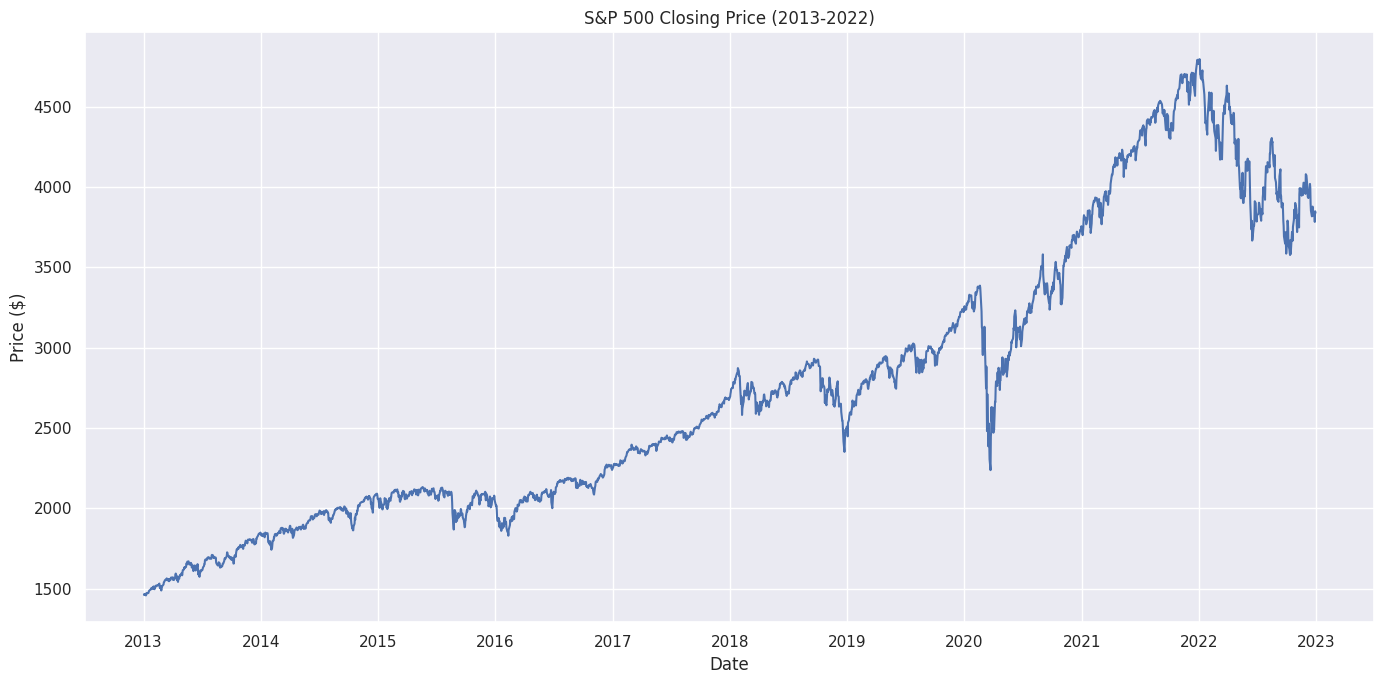


Selected time series shape: (2518, 1)


In [52]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_theme()

# Download S&P 500 data for the last 10 years
sp500 = yf.download('^GSPC', start='2013-01-01', end='2022-12-31')

# Display the first few rows of the dataset
print("S&P 500 Dataset:")
print(sp500.head())

# Display basic information about the dataset
print("\nDataset information:")
print(sp500.info())

# Calculate basic summary statistics
print("\nSummary Statistics:")
print(sp500['Close'].describe())

# Check for missing values
print("\nMissing values in each column:")
print(sp500.isnull().sum())

# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(sp500.index, sp500['Close'])
plt.title('S&P 500 Closing Price (2013-2022)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Select the closing price as our primary time series for analysis
ts_data = sp500['Close']
print("\nSelected time series shape:", ts_data.shape)

### Step 2: Time Series Characteristics and Visualization
Let's analyze the characteristics of the time series through various visualizations.

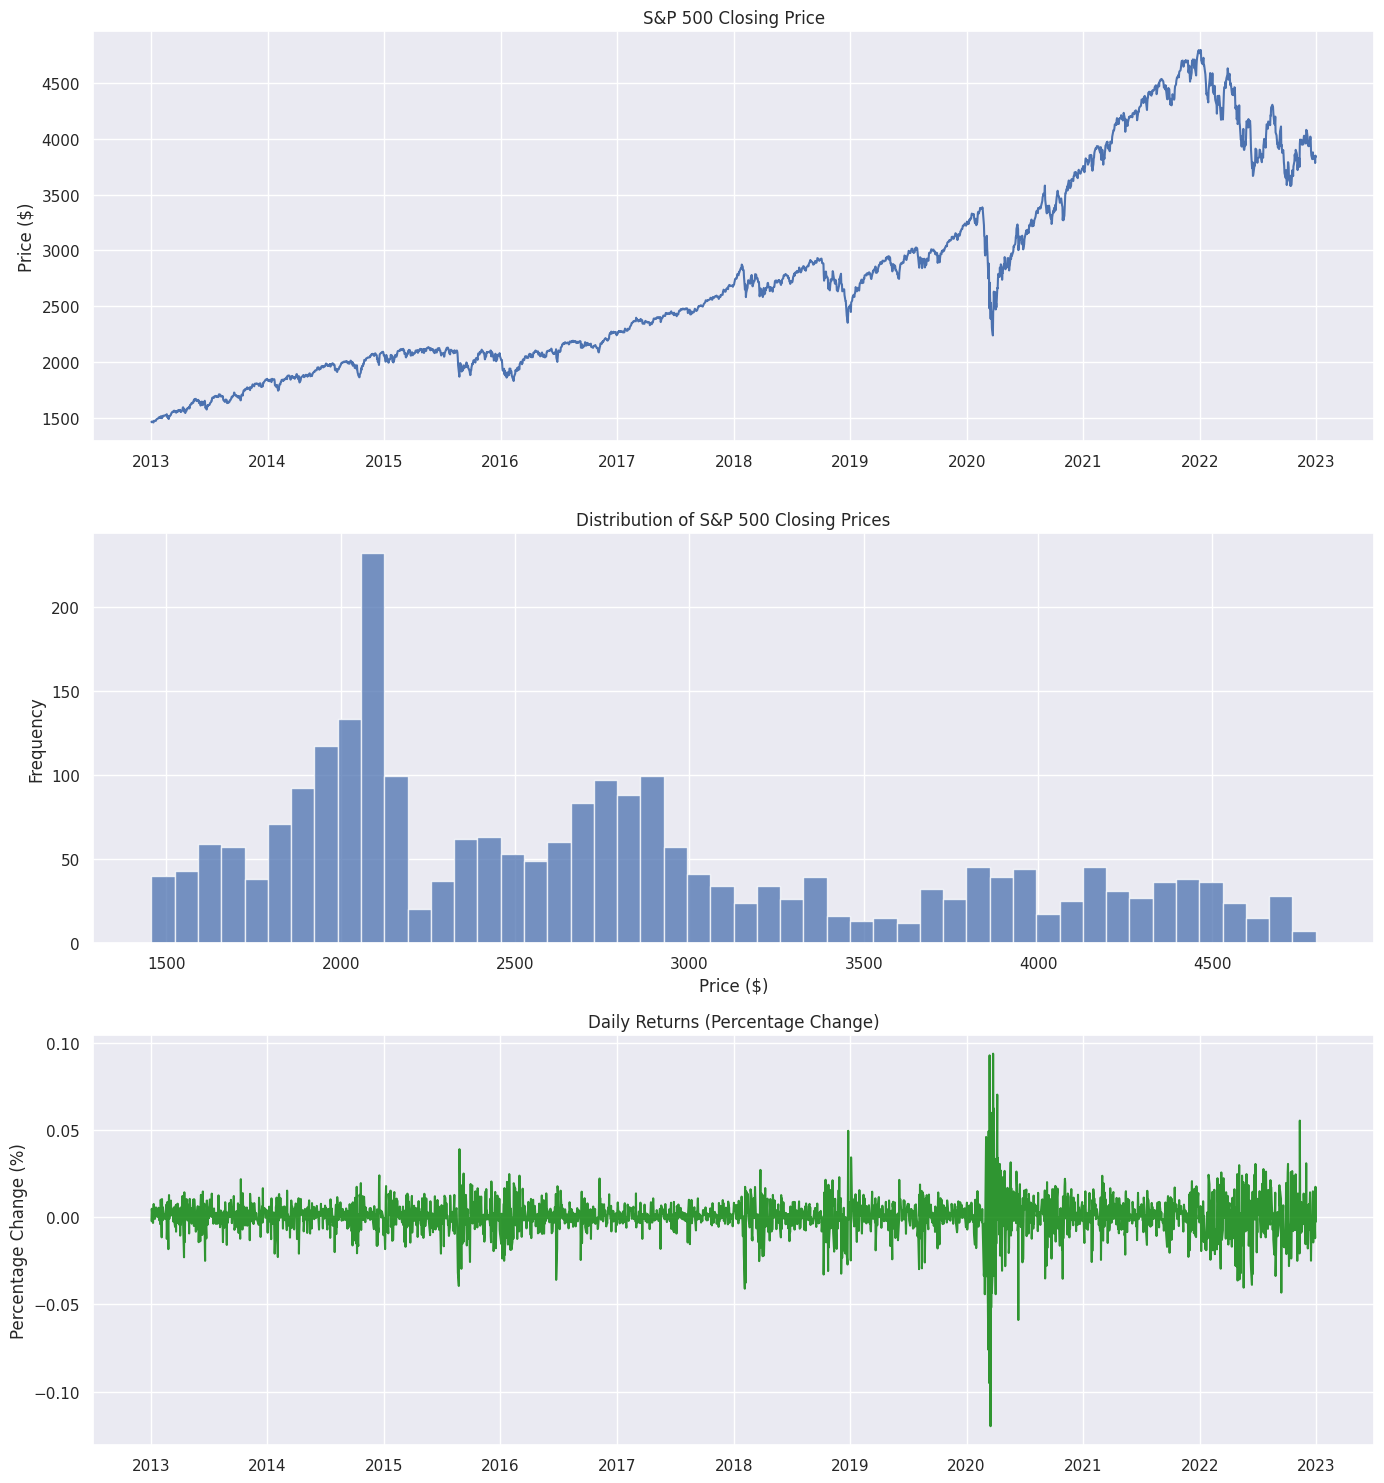

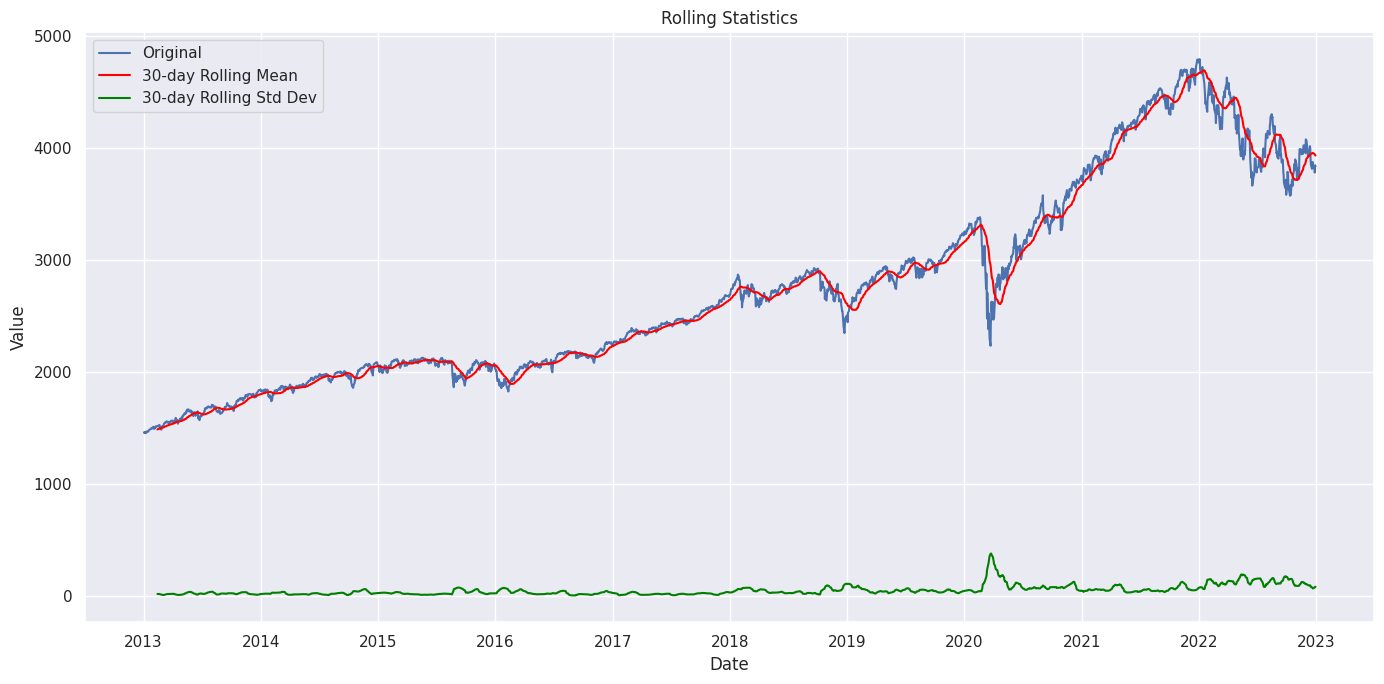

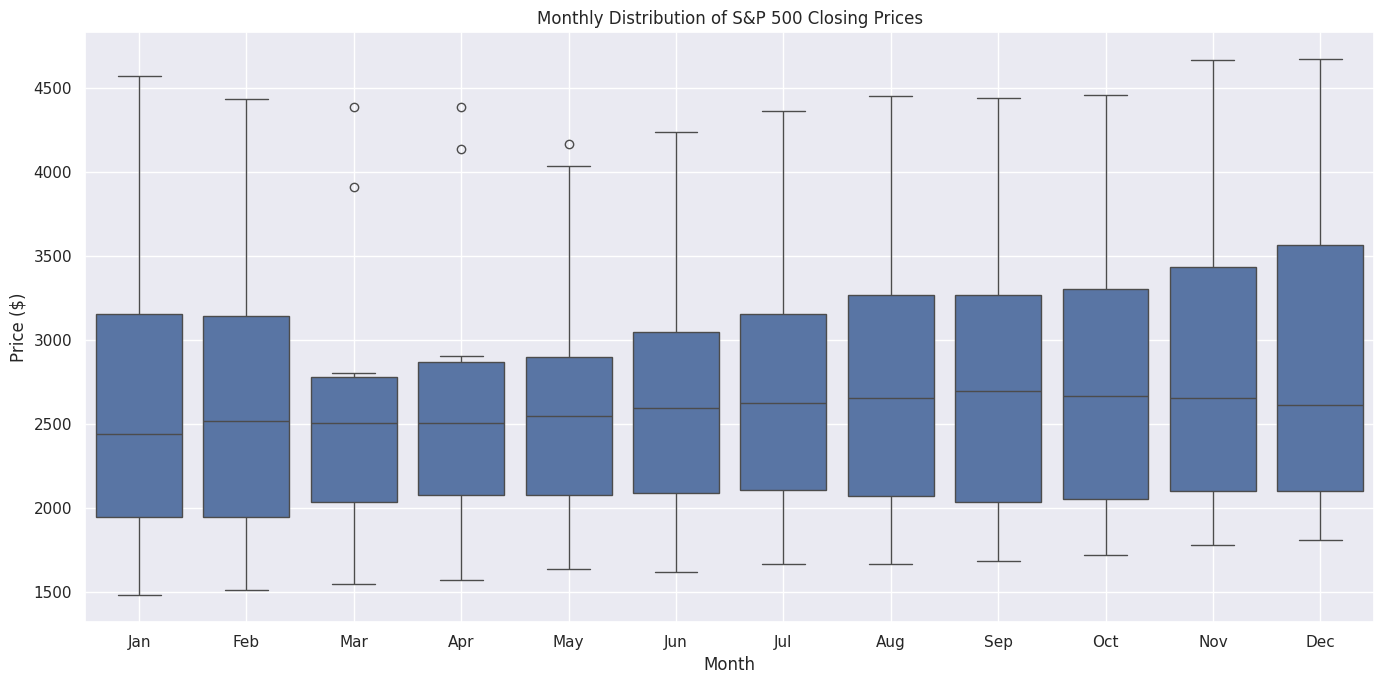

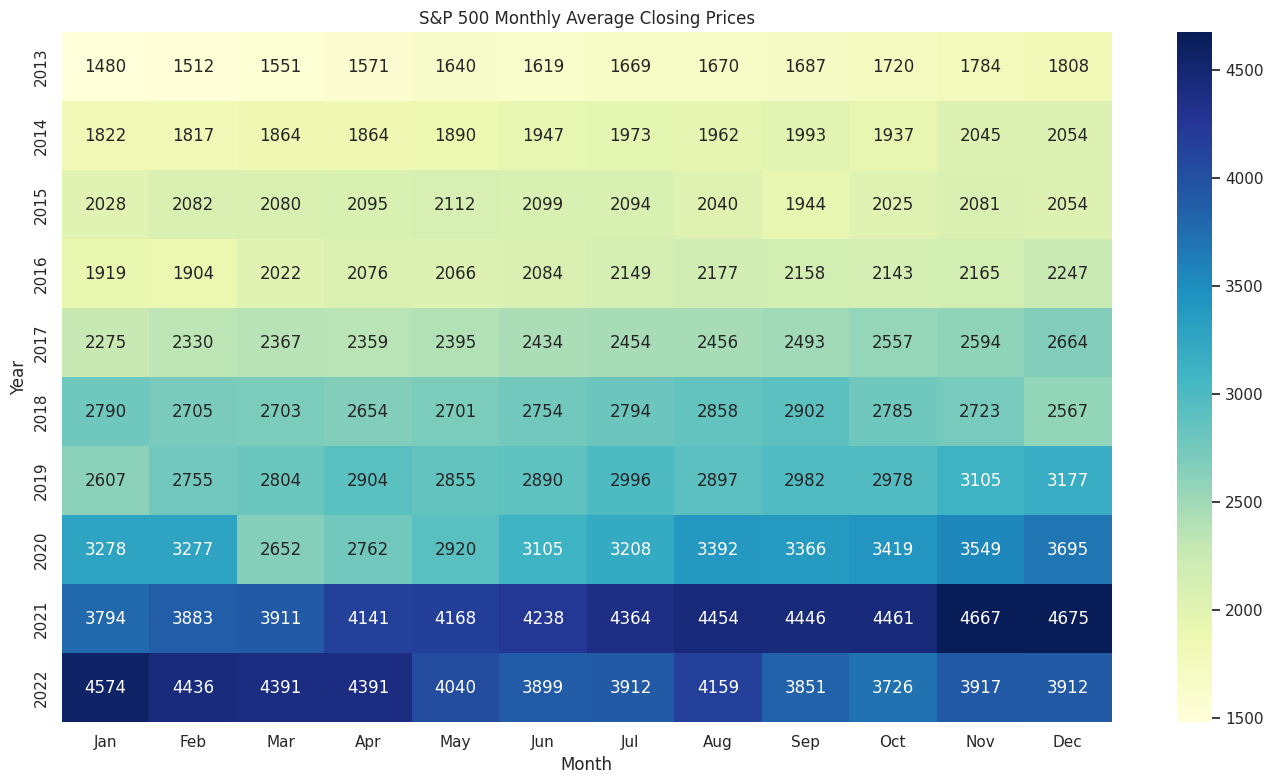

In [53]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# Plot 1: Original time series
axes[0].plot(ts_data)
axes[0].set_title('S&P 500 Closing Price')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True)

# Plot 2: Histogram of values
axes[1].hist(ts_data, bins=50, alpha=0.75)
axes[1].set_title('Distribution of S&P 500 Closing Prices')
axes[1].set_xlabel('Price ($)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Plot 3: Daily returns (percentage change)
daily_returns = ts_data.pct_change().dropna()
axes[2].plot(daily_returns, color='green', alpha=0.8)
axes[2].set_title('Daily Returns (Percentage Change)')
axes[2].set_ylabel('Percentage Change (%)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Calculate and plot rolling statistics (mean and std dev)
# Using a 30-day window for monthly statistics
window = 30
rolling_mean = ts_data.rolling(window=window).mean()
rolling_std = ts_data.rolling(window=window).std()

plt.figure(figsize=(14, 7))
plt.plot(ts_data, label='Original')
plt.plot(rolling_mean, label=f'{window}-day Rolling Mean', color='red')
plt.plot(rolling_std, label=f'{window}-day Rolling Std Dev', color='green')
plt.title('Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create monthly boxplots to visualize seasonal patterns
# Resample to monthly data and create a month column
monthly_data = ts_data.resample('M').mean()
monthly_data = pd.DataFrame(monthly_data)
monthly_data['Month'] = monthly_data.index.strftime('%b')
monthly_data['Year'] = monthly_data.index.year

# Rename the '^GSPC' column to 'Close' for consistency
monthly_data = monthly_data.rename(columns={'^GSPC': 'Close'})

# Create boxplots by month
plt.figure(figsize=(14, 7))
sns.boxplot(x='Month', y='Close', data=monthly_data)
plt.title('Monthly Distribution of S&P 500 Closing Prices')
plt.xlabel('Month')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a heatmap to visualize yearly patterns
# Pivot the data to create a year x month matrix
heatmap_data = pd.pivot_table(
    monthly_data,
    values='Close',
    index='Year',
    columns='Month',
    aggfunc='mean'
)

# Reorder the columns to match calendar months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
heatmap_data = heatmap_data[month_order]

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('S&P 500 Monthly Average Closing Prices')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

### Step 3: Stationarity Testing and Transformation
Now, let's test for stationarity using the Dickey-Fuller test and apply transformations to make the data stationary.

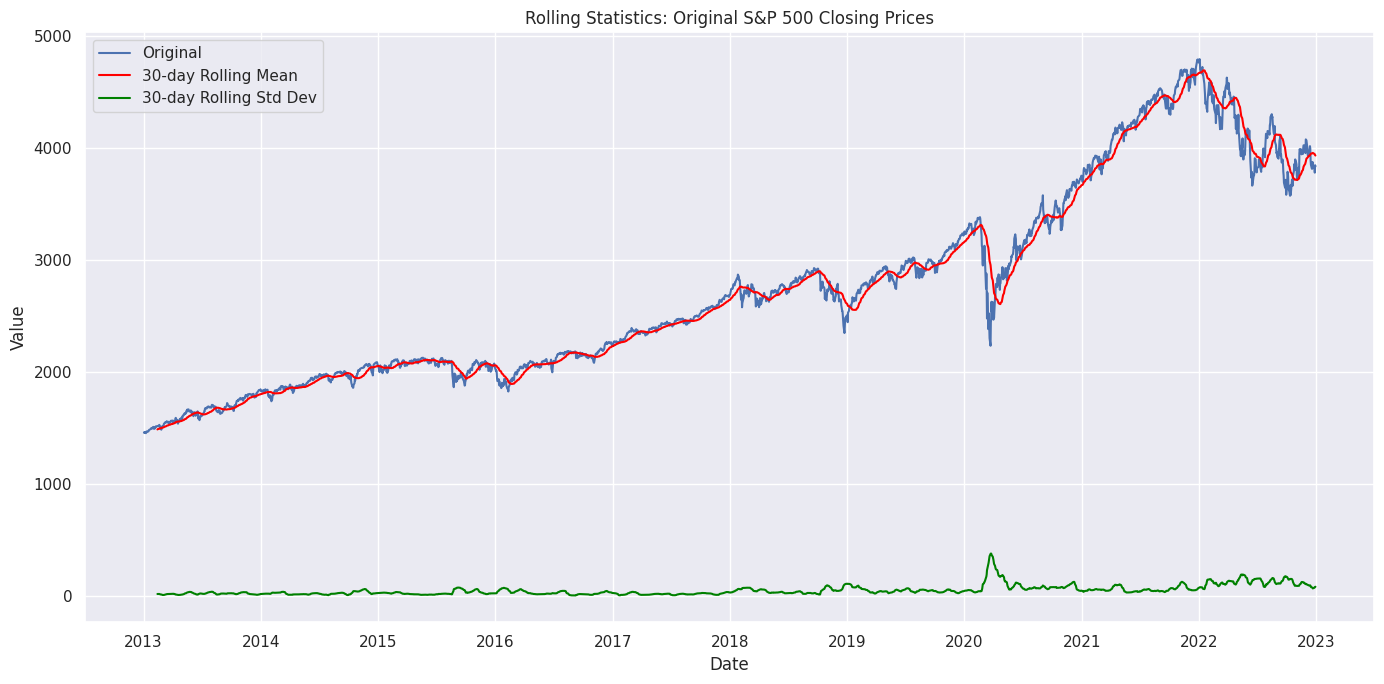

Results of Dickey-Fuller Test for Original S&P 500 Closing Prices:
Test Statistic                   -1.031209
p-value                           0.741712
#Lags Used                       10.000000
Number of Observations Used    2507.000000
Critical Value (1%)              -3.432961
Critical Value (5%)              -2.862694
Critical Value (10%)             -2.567384
dtype: float64
Conclusion: The series is NON-STATIONARY (fail to reject the null hypothesis)



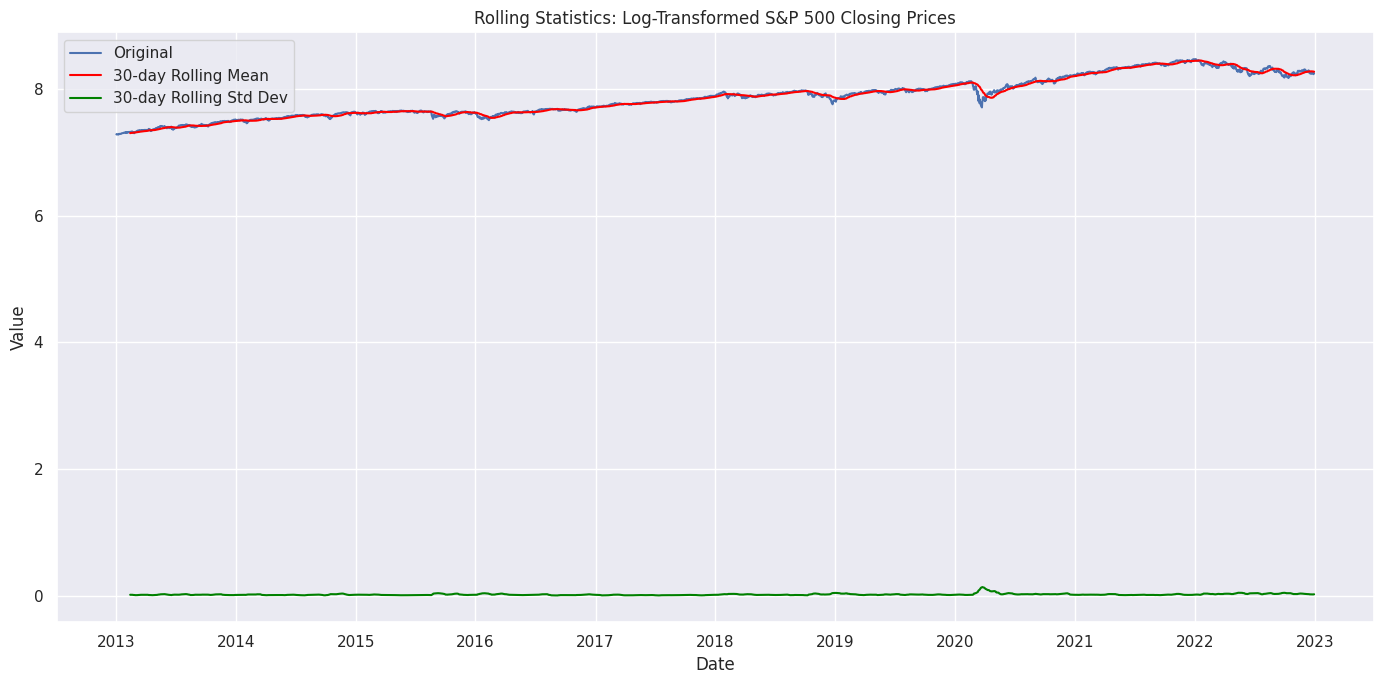

Results of Dickey-Fuller Test for Log-Transformed S&P 500 Closing Prices:
Test Statistic                   -1.411355
p-value                           0.576820
#Lags Used                       10.000000
Number of Observations Used    2507.000000
Critical Value (1%)              -3.432961
Critical Value (5%)              -2.862694
Critical Value (10%)             -2.567384
dtype: float64
Conclusion: The series is NON-STATIONARY (fail to reject the null hypothesis)



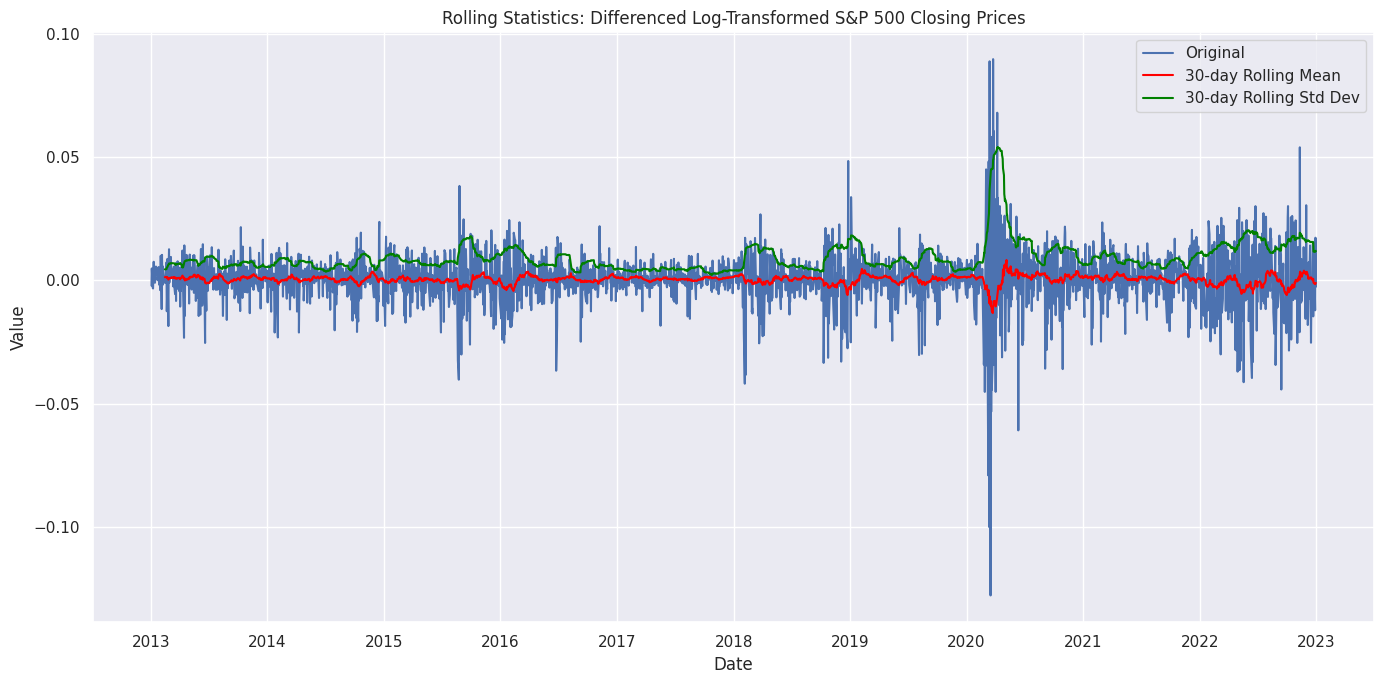

Results of Dickey-Fuller Test for Differenced Log-Transformed S&P 500 Closing Prices:
Test Statistic                -1.583739e+01
p-value                        9.782659e-29
#Lags Used                     9.000000e+00
Number of Observations Used    2.507000e+03
Critical Value (1%)           -3.432961e+00
Critical Value (5%)           -2.862694e+00
Critical Value (10%)          -2.567384e+00
dtype: float64
Conclusion: The series is STATIONARY (reject the null hypothesis)

Final transformed data (first 5 values):
Ticker         ^GSPC
Date                
2013-01-03 -0.002088
2013-01-04  0.004853
2013-01-07 -0.003128
2013-01-08 -0.003248
2013-01-09  0.002652


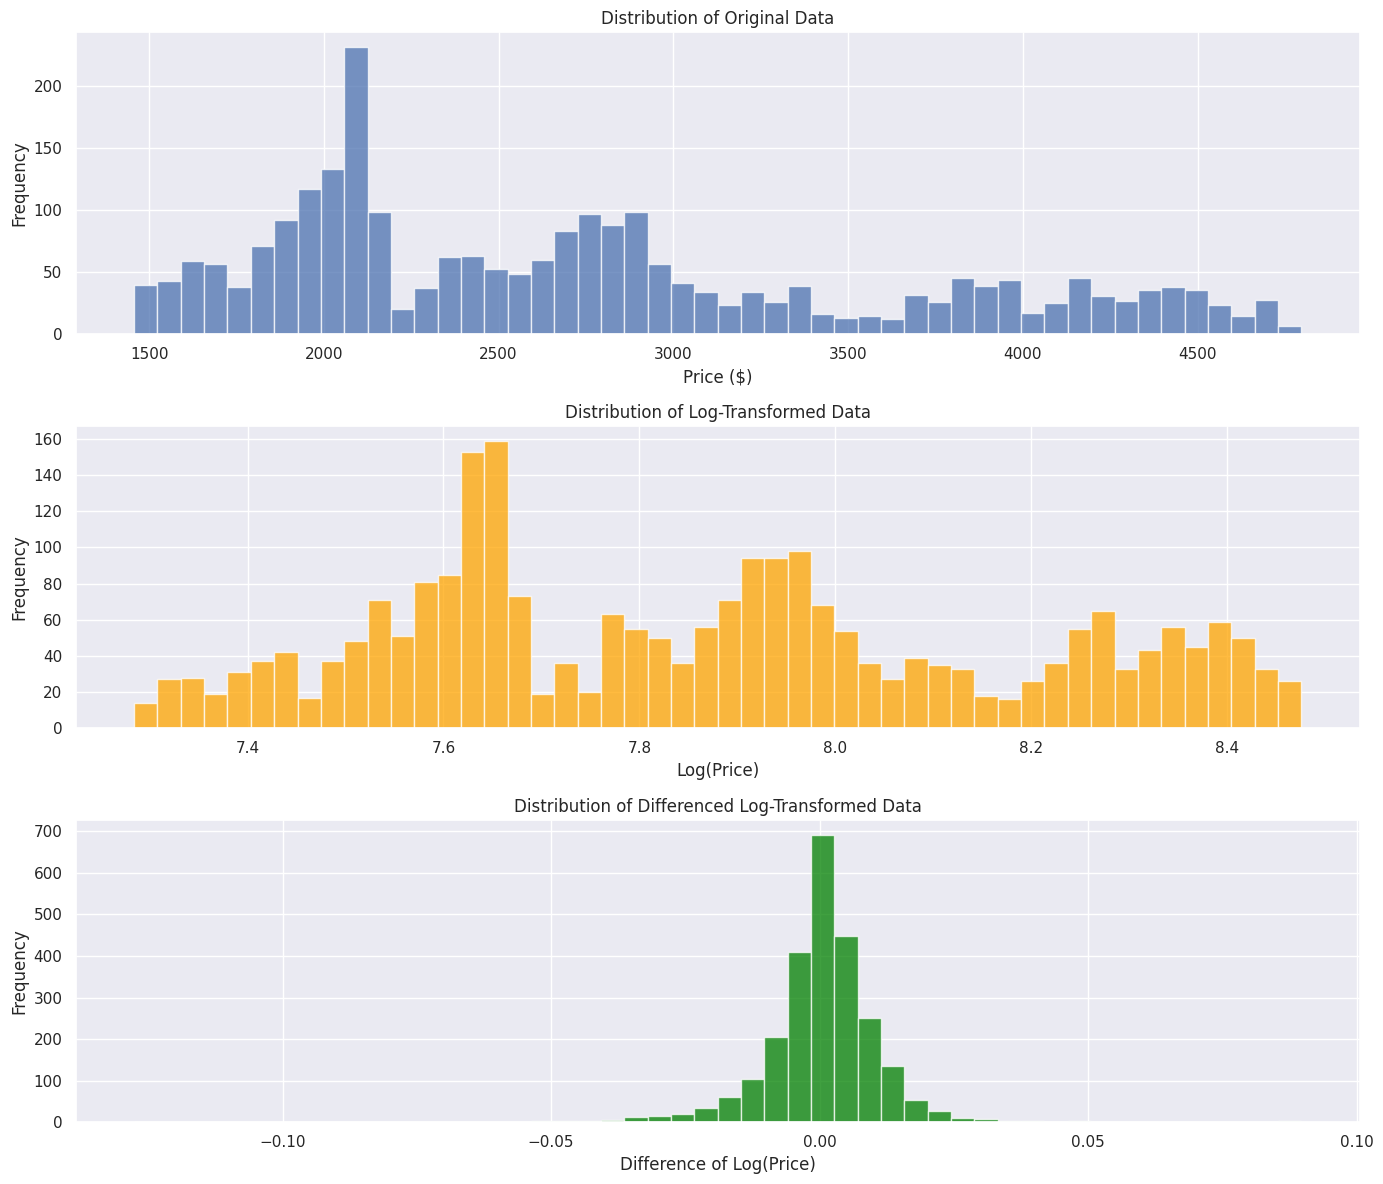

In [54]:
def test_stationarity(timeseries, title=''):
    """
    Test for stationarity using the Augmented Dickey-Fuller test
    """
    # Calculate rolling statistics
    window = 30
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()

    # Plot rolling statistics
    plt.figure(figsize=(14, 7))
    plt.plot(timeseries, label='Original')
    plt.plot(rolling_mean, label=f'{window}-day Rolling Mean', color='red')
    plt.plot(rolling_std, label=f'{window}-day Rolling Std Dev', color='green')
    plt.title(f'Rolling Statistics: {title}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Perform Dickey-Fuller test
    print(f'Results of Dickey-Fuller Test for {title}:')
    dftest = adfuller(timeseries.dropna())
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

    # Interpret the test results
    if dftest[1] <= 0.05:
        print("Conclusion: The series is STATIONARY (reject the null hypothesis)\n")
    else:
        print("Conclusion: The series is NON-STATIONARY (fail to reject the null hypothesis)\n")

# Test stationarity on original time series
test_stationarity(ts_data, 'Original S&P 500 Closing Prices')

# Apply log transformation to stabilize variance
ts_log = np.log(ts_data)

# Test stationarity on log-transformed data
test_stationarity(ts_log, 'Log-Transformed S&P 500 Closing Prices')

# Apply first-order differencing to remove trend
ts_log_diff = ts_log.diff().dropna()

# Test stationarity on differenced log-transformed data
test_stationarity(ts_log_diff, 'Differenced Log-Transformed S&P 500 Closing Prices')

# Verify the final transformed data
print("Final transformed data (first 5 values):")
print(ts_log_diff.head())

# Plot histograms to compare distributions
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Original data distribution
axes[0].hist(ts_data, bins=50, alpha=0.75)
axes[0].set_title('Distribution of Original Data')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')

# Log-transformed data distribution
axes[1].hist(ts_log, bins=50, alpha=0.75, color='orange')
axes[1].set_title('Distribution of Log-Transformed Data')
axes[1].set_xlabel('Log(Price)')
axes[1].set_ylabel('Frequency')

# Differenced log-transformed data distribution
axes[2].hist(ts_log_diff, bins=50, alpha=0.75, color='green')
axes[2].set_title('Distribution of Differenced Log-Transformed Data')
axes[2].set_xlabel('Difference of Log(Price)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Step 4: Time Series Decomposition
Let's decompose our time series into trend, seasonal, and residual components.

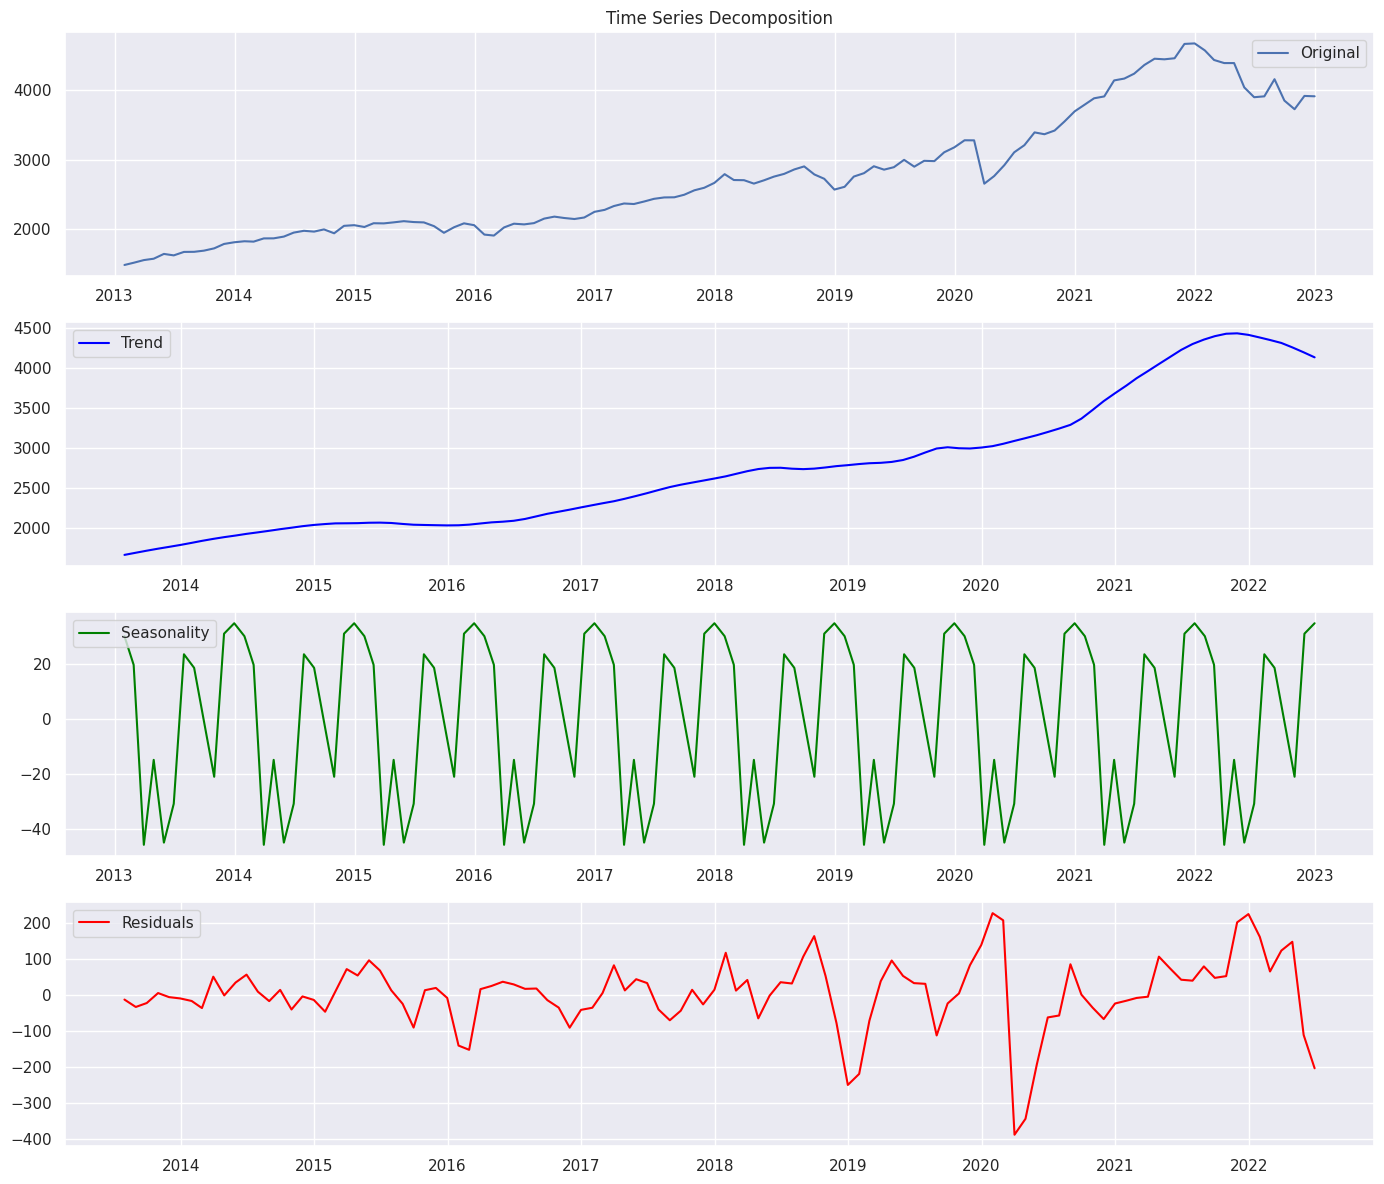

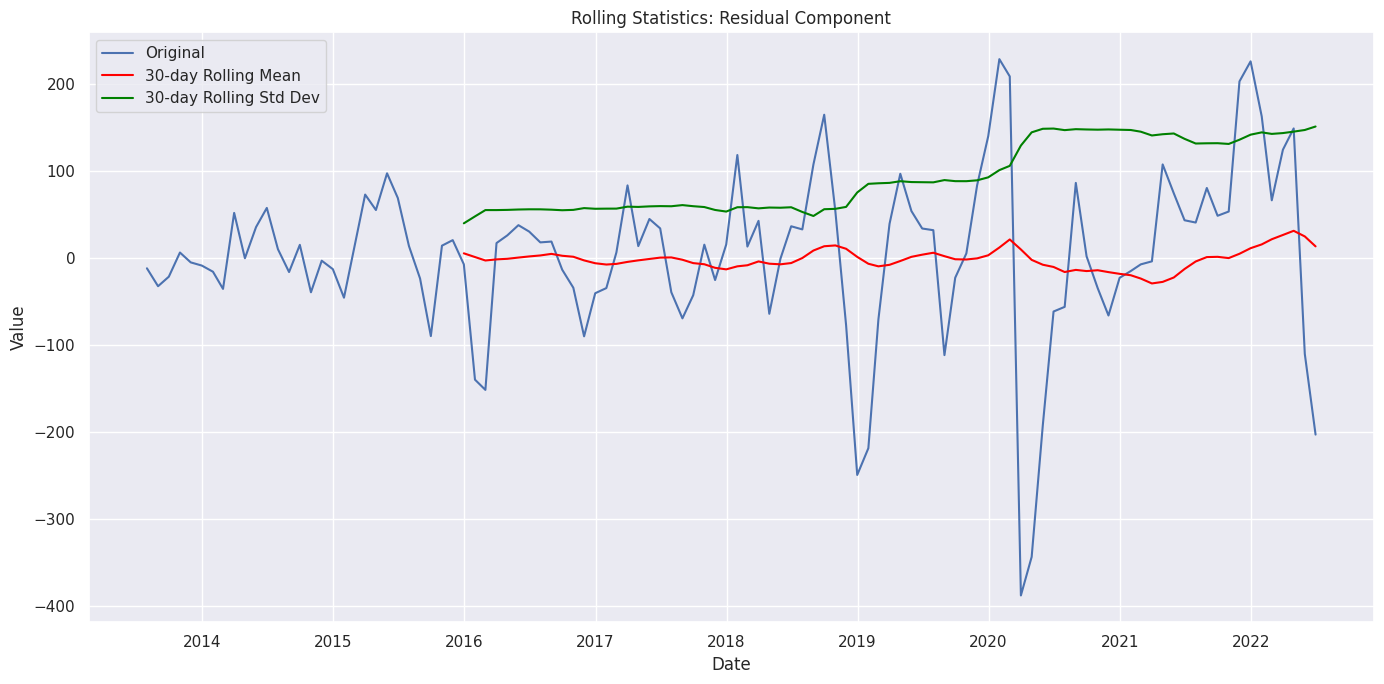

Results of Dickey-Fuller Test for Residual Component:
Test Statistic                -6.594910e+00
p-value                        6.964602e-09
#Lags Used                     1.000000e+00
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64
Conclusion: The series is STATIONARY (reject the null hypothesis)

Statistical Summary of Time Series Components:
                                                Mean  \
Original  Ticker
^GSPC    2741.813346
dtype: float64   
Trend                                     2737.76421   
Seasonal                                        -0.0   
Residual                                    4.532221   

                                            Std Dev  \
Original  Ticker
^GSPC    873.994953
dtype: float64   
Trend                                    811.008743   
Seasonal                                  29.219642   
Residual

In [55]:
# Resample data to monthly frequency for clearer seasonal patterns
monthly_ts = ts_data.resample('M').mean()

# Decompose the time series using additive model
decomposition = seasonal_decompose(monthly_ts, model='additive', period=12)

# Plot the decomposition
plt.figure(figsize=(14, 12))

# Original
plt.subplot(411)
plt.plot(monthly_ts, label='Original')
plt.legend(loc='best')
plt.title('Time Series Decomposition')

# Trend
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend(loc='best')

# Seasonality
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend(loc='best')

# Residuals
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Store components for further analysis
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Check stationarity of the residual component
residual_dropna = residual.dropna()
test_stationarity(residual_dropna, 'Residual Component')

# Show statistical properties of each component
components = {
    'Original': monthly_ts,
    'Trend': trend,
    'Seasonal': seasonal,
    'Residual': residual
}

# Create a summary table
summary = pd.DataFrame({
    'Mean': {name: component.dropna().mean() for name, component in components.items()},
    'Std Dev': {name: component.dropna().std() for name, component in components.items()},
    'Min': {name: component.dropna().min() for name, component in components.items()},
    'Max': {name: component.dropna().max() for name, component in components.items()}
})

print("Statistical Summary of Time Series Components:")
print(summary)

### Step 5: Autocorrelation Analysis
Now, let's analyze the autocorrelation structure of our stationary series.

<Figure size 1400x700 with 0 Axes>

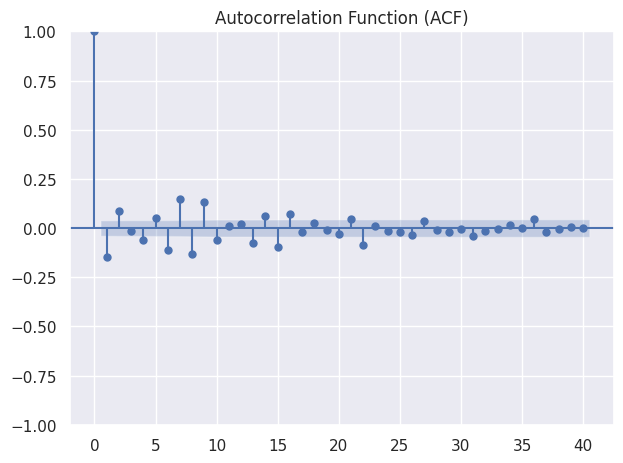

<Figure size 1400x700 with 0 Axes>

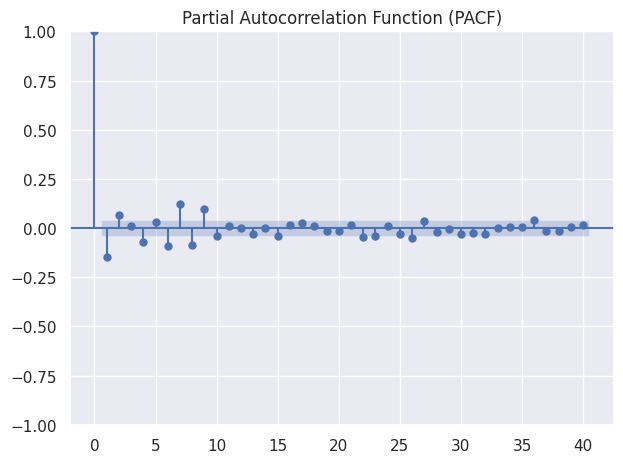

Interpretation of ACF and PACF Plots:
1. ACF: Shows correlation between a time series and its lags.
2. PACF: Shows direct correlation between a time series and its lags after removing effects of intermediate lags.

Based on these plots, we can determine:
- If ACF tails off gradually and PACF cuts off after lag p, an AR(p) model may be appropriate.
- If ACF cuts off after lag q and PACF tails off gradually, an MA(q) model may be appropriate.
- If both ACF and PACF tail off gradually, an ARMA model may be appropriate.


In [56]:
# Prepare the stationary series (differenced log-transformed data)
stationary_series = ts_log_diff.dropna()

# Calculate and plot ACF
plt.figure(figsize=(14, 7))
plot_acf(stationary_series, lags=40, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate and plot PACF
plt.figure(figsize=(14, 7))
plot_pacf(stationary_series, lags=40, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Interpret ACF and PACF plots
print("Interpretation of ACF and PACF Plots:")
print("1. ACF: Shows correlation between a time series and its lags.")
print("2. PACF: Shows direct correlation between a time series and its lags after removing effects of intermediate lags.")
print("")
print("Based on these plots, we can determine:")
print("- If ACF tails off gradually and PACF cuts off after lag p, an AR(p) model may be appropriate.")
print("- If ACF cuts off after lag q and PACF tails off gradually, an MA(q) model may be appropriate.")
print("- If both ACF and PACF tail off gradually, an ARMA model may be appropriate.")

### Step 6: Time Series Modeling
Finally, let's build and evaluate time series models based on our analysis.

ARIMA(1, 0, 0) Model Summary:
AIC: 1452.9540
BIC: 1461.2914


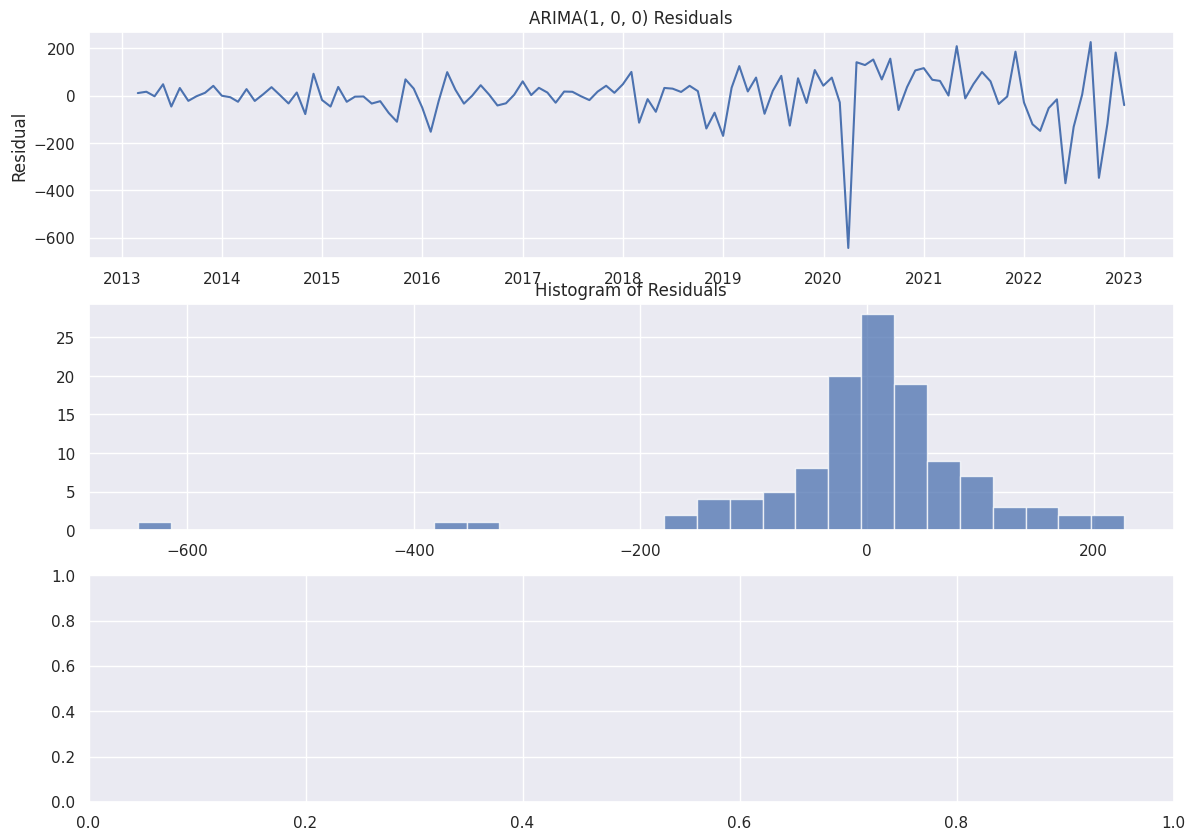

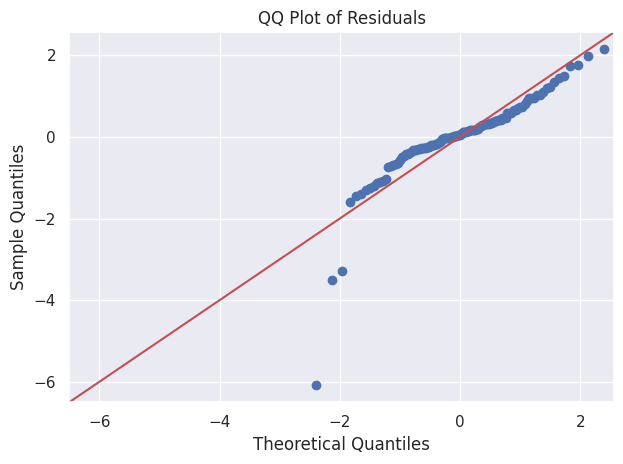

ARIMA(0, 0, 1) Model Summary:
AIC: 1452.6885
BIC: 1461.0259


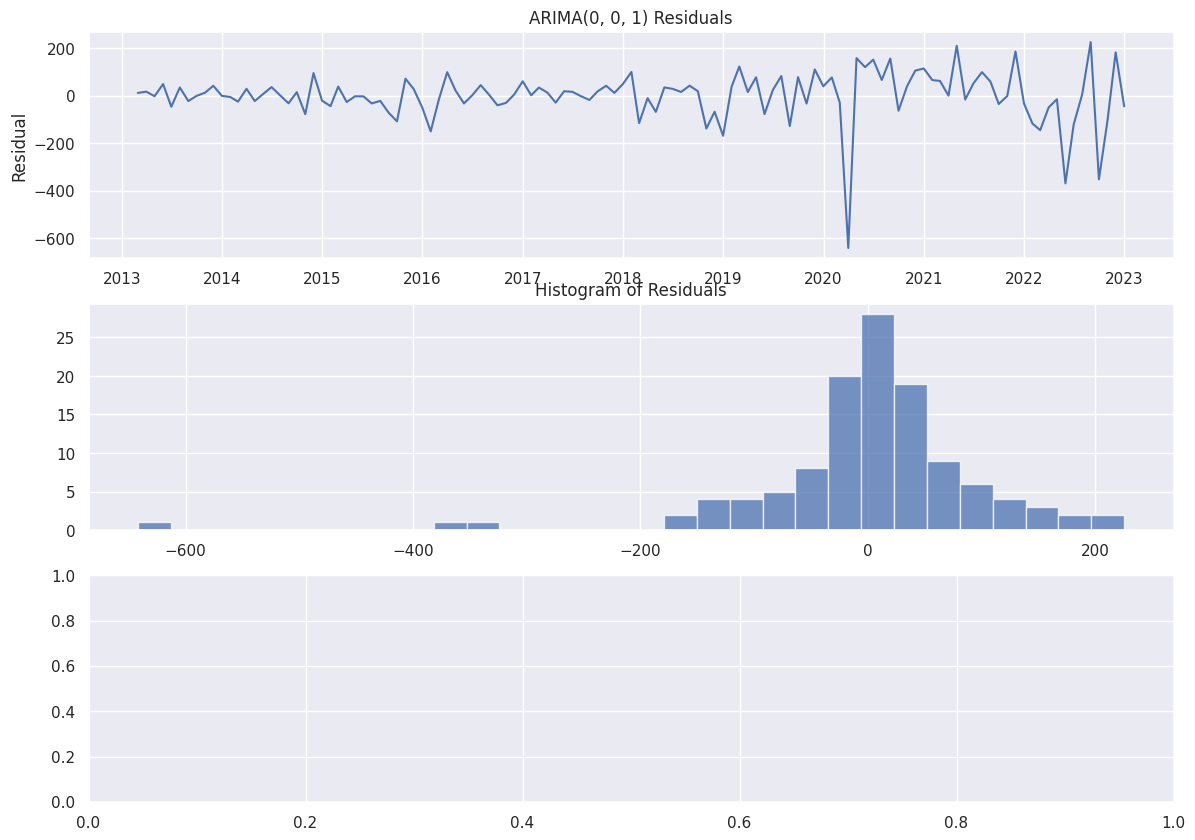

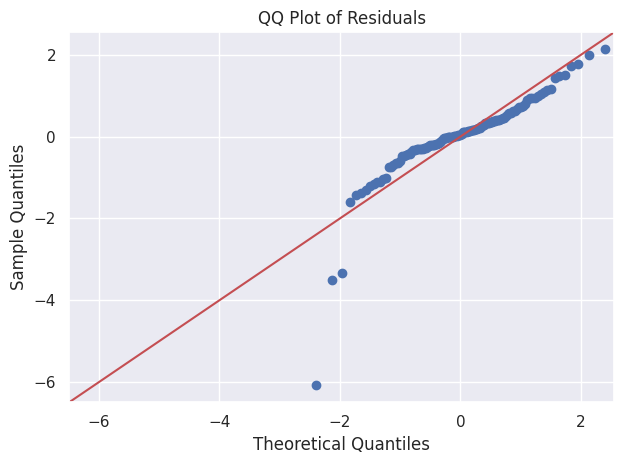

ARIMA(1, 0, 1) Model Summary:
AIC: 1453.9936
BIC: 1465.1101


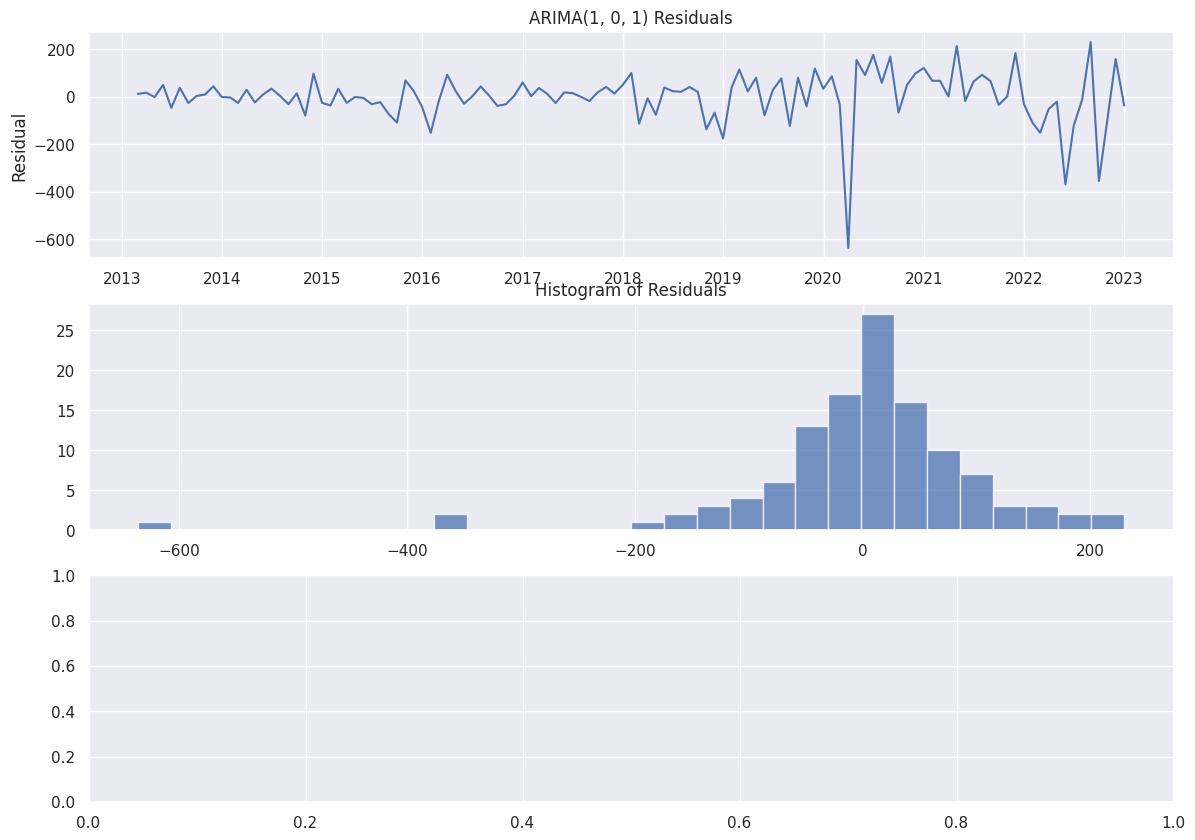

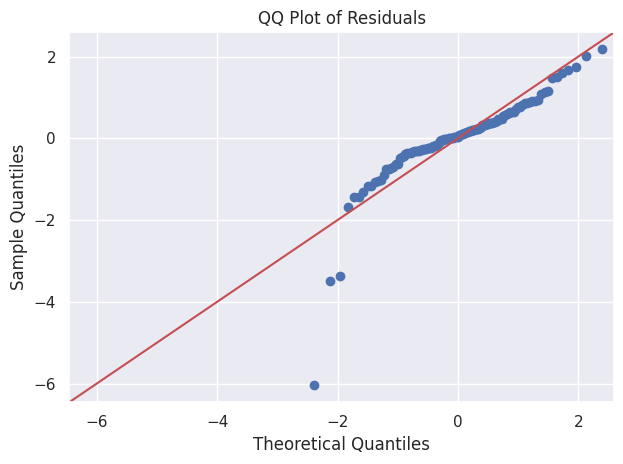

ARIMA(1, 1, 1) Model Summary:
AIC: 1455.6978
BIC: 1464.0352


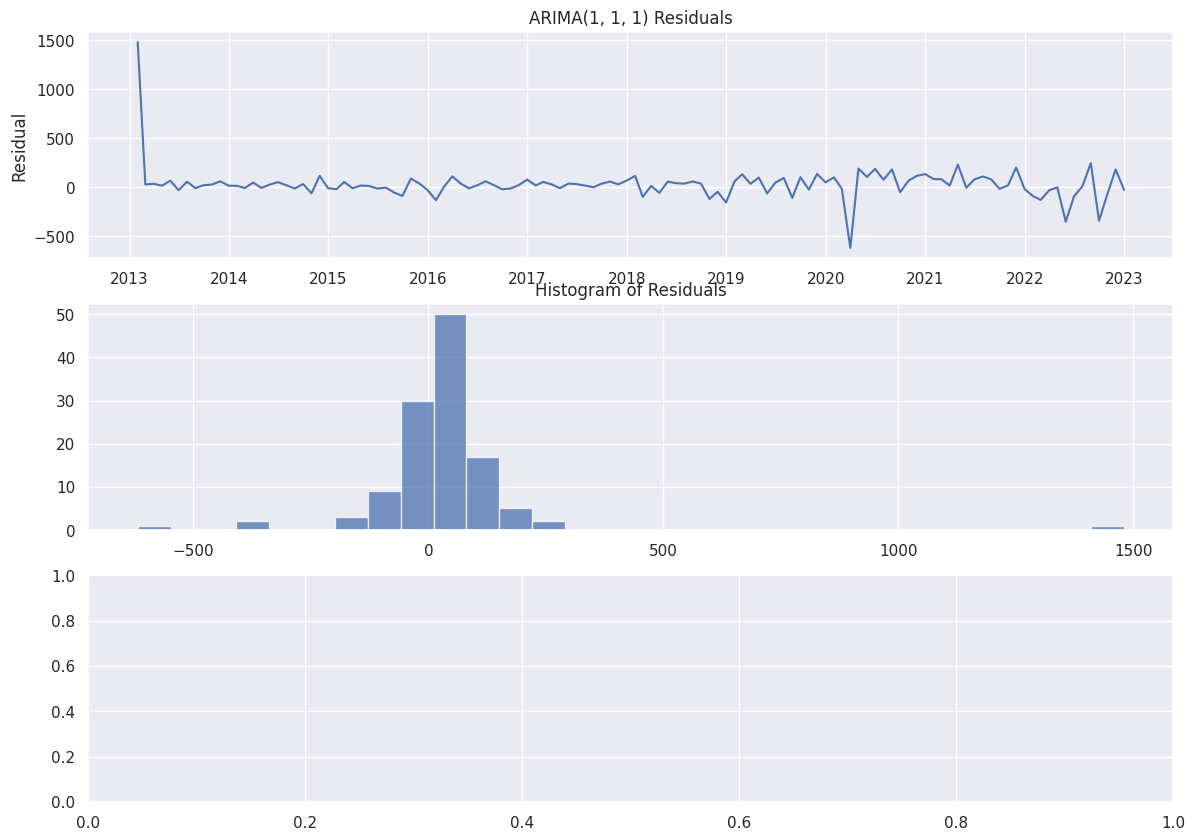

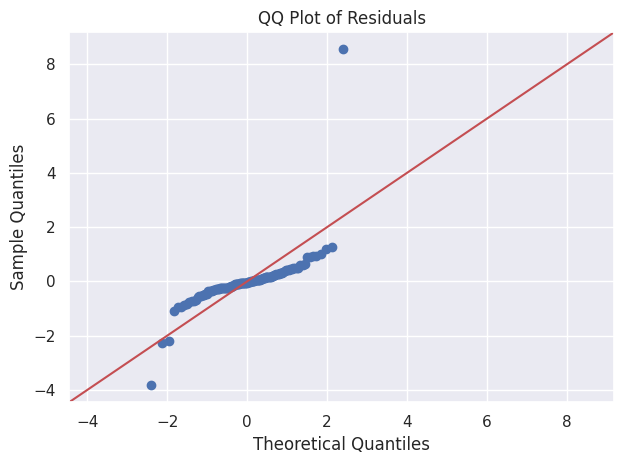


Model Comparison by AIC/BIC:
                      AIC          BIC
AR(1)         1452.954032  1461.291402
MA(1)         1452.688507  1461.025878
ARMA(1,1)     1453.993601  1465.110095
ARIMA(1,1,1)  1455.697826  1464.035197

Best model based on AIC: MA(1)


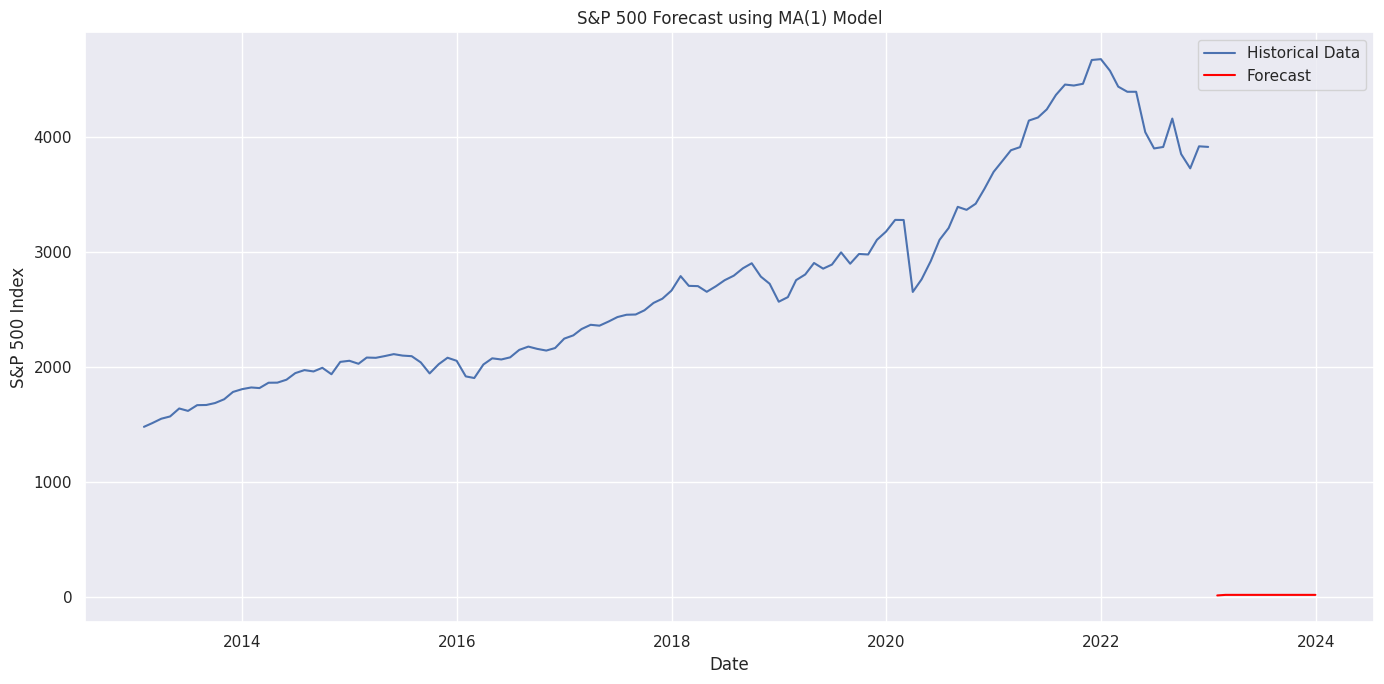


Model Performance Metrics:
Mean Absolute Error (MAE): 58.9843
Root Mean Squared Error (RMSE): 94.7739
Mean Absolute Percentage Error (MAPE): nan%


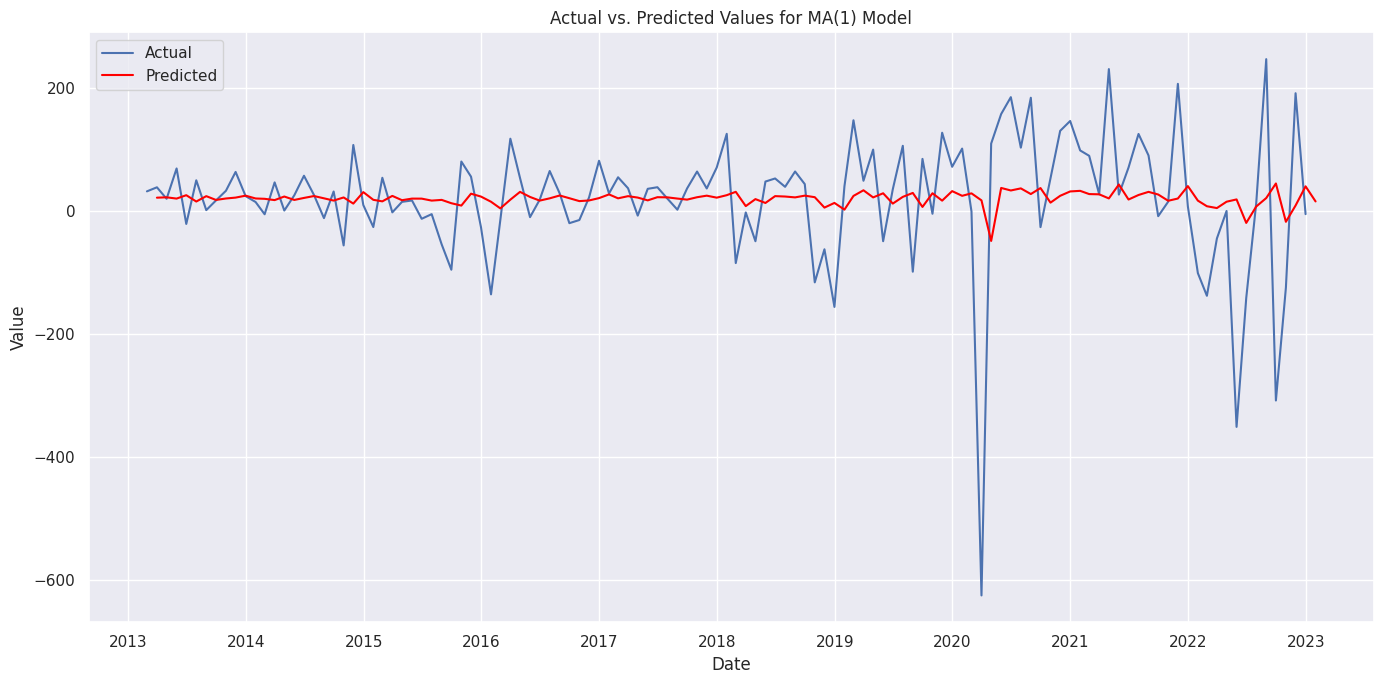

In [57]:
# Define a function to fit and evaluate ARIMA models
def fit_arima_model(series, order, title=''):
    """
    Fit an ARIMA model and evaluate its performance
    """
    try:
        # Fit the model
        model = ARIMA(series, order=order)
        model_fit = model.fit()

        # Print model summary
        print(f"ARIMA{order} Model Summary:")
        print(f"AIC: {model_fit.aic:.4f}")
        print(f"BIC: {model_fit.bic:.4f}")

        # Plot residuals
        plt.figure(figsize=(14, 10))

        # Residuals over time
        plt.subplot(311)
        plt.plot(model_fit.resid)
        plt.title(f'ARIMA{order} Residuals')
        plt.ylabel('Residual')
        plt.grid(True)

        # Histogram of residuals
        plt.subplot(312)
        plt.hist(model_fit.resid, bins=30, alpha=0.75)
        plt.title('Histogram of Residuals')
        plt.grid(True)

        # QQ plot of residuals
        plt.subplot(313)
        import statsmodels.api as sm
        sm.graphics.qqplot(model_fit.resid, line='45', fit=True)
        plt.title('QQ Plot of Residuals')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Return the fitted model
        return model_fit

    except Exception as e:
        print(f"Error fitting ARIMA{order}: {e}")
        return None

# Based on ACF and PACF plots, we'll try a few different ARIMA models
# First, let's use monthly data for more manageable modeling
monthly_stationary = monthly_ts.diff().dropna()

# Try AR model - ARIMA(1,0,0)
ar_model = fit_arima_model(monthly_stationary, order=(1, 0, 0), title='AR(1)')

# Try MA model - ARIMA(0,0,1)
ma_model = fit_arima_model(monthly_stationary, order=(0, 0, 1), title='MA(1)')

# Try ARMA model - ARIMA(1,0,1)
arma_model = fit_arima_model(monthly_stationary, order=(1, 0, 1), title='ARMA(1,1)')

# Try ARIMA model - ARIMA(1,1,1)
# Note: We're using original data here since the order includes differencing (d=1)
arima_model = fit_arima_model(monthly_ts, order=(1, 1, 1), title='ARIMA(1,1,1)')

# Compare models by AIC/BIC
models = {
    'AR(1)': ar_model,
    'MA(1)': ma_model,
    'ARMA(1,1)': arma_model,
    'ARIMA(1,1,1)': arima_model
}

# Create a comparison table
comparison = pd.DataFrame({
    'AIC': {name: model.aic if model is not None else np.nan for name, model in models.items()},
    'BIC': {name: model.bic if model is not None else np.nan for name, model in models.items()},
})

print("\nModel Comparison by AIC/BIC:")
print(comparison)

# Identify the best model (lowest AIC)
best_model_name = comparison['AIC'].idxmin()
print(f"\nBest model based on AIC: {best_model_name}")

# Get the best model
best_model = models[best_model_name]

# Forecast with the best model
forecast_steps = 12  # One year ahead
forecast = best_model.forecast(steps=forecast_steps)

# Create a date range for the forecast
last_date = monthly_ts.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps+1, freq='M')[1:]

# Plot the original series and forecast
plt.figure(figsize=(14, 7))
plt.plot(monthly_ts, label='Historical Data')
plt.plot(forecast_dates, forecast, color='red', label='Forecast')
plt.title(f'S&P 500 Forecast using {best_model_name} Model')
plt.xlabel('Date')
plt.ylabel('S&P 500 Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate in-sample forecast (one-step ahead predictions)
in_sample_forecast = best_model.predict(start=1, end=len(monthly_stationary))

# Evaluate model accuracy
actual = monthly_stationary
predicted = in_sample_forecast

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate error metrics
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print("\nModel Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

# Plot actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(actual.index, actual, label='Actual')
plt.plot(predicted.index, predicted, color='red', label='Predicted')
plt.title(f'Actual vs. Predicted Values for {best_model_name} Model')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Part 3: Neural Networks Implementation and Optimization

### Step 1: Load libraries and prepare the datasets

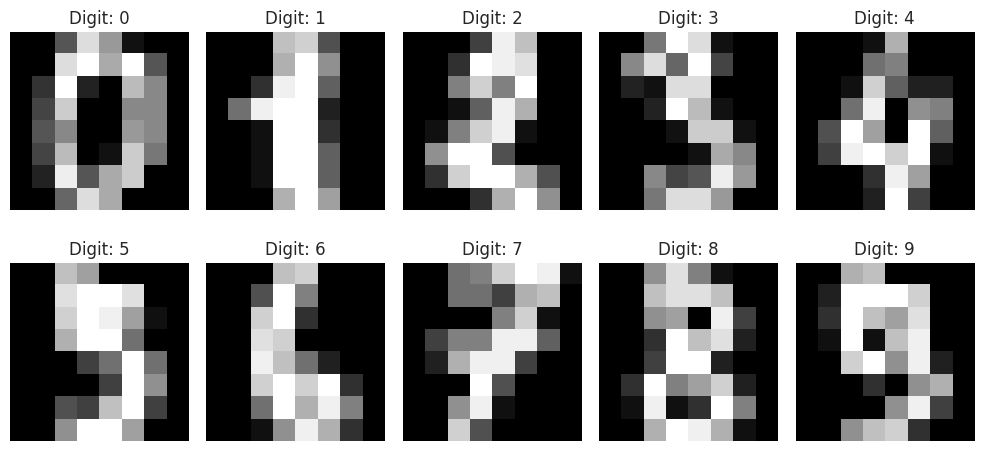

Digits dataset: 1797 samples, 64 features


In [58]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.datasets import load_digits

# For deep learning
import tensorflow as tf
from tensorflow import keras
from keras import layers

# For PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# Load Digits dataset for classification
digits = load_digits()
X_digits = digits.data
y_digits = digits.target


# Display sample digits
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(digits.images[i], cmap='gray')
    plt.title(f'Digit: {digits.target[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print information about dataset
print(f"Digits dataset: {X_digits.shape[0]} samples, {X_digits.shape[1]} features")

### Step 2: Preprocess data for neural networks

In [59]:
# Split digits data into train and test sets
X_digits_train, X_digits_test, y_digits_train, y_digits_test = train_test_split(
    X_digits, y_digits, test_size=0.2, random_state=42)

# Normalize digits data (scale to [0, 1])
X_digits_train = X_digits_train / 16.0
X_digits_test = X_digits_test / 16.0

# Split wine data into train and test sets
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(
    X_wine, y_wine, test_size=0.2, random_state=42)

# Standardize wine features
scaler = StandardScaler()
X_wine_train_scaled = scaler.fit_transform(X_wine_train)
X_wine_test_scaled = scaler.transform(X_wine_test)

# Convert digits data to PyTorch tensors
X_digits_train_tensor = torch.tensor(X_digits_train, dtype=torch.float32)
y_digits_train_tensor = torch.tensor(y_digits_train, dtype=torch.long)
X_digits_test_tensor = torch.tensor(X_digits_test, dtype=torch.float32)
y_digits_test_tensor = torch.tensor(y_digits_test, dtype=torch.long)

# Convert wine data to PyTorch tensors
X_wine_train_tensor = torch.tensor(X_wine_train_scaled, dtype=torch.float32)
y_wine_train_tensor = torch.tensor(y_wine_train, dtype=torch.float32).view(-1, 1)
X_wine_test_tensor = torch.tensor(X_wine_test_scaled, dtype=torch.float32)
y_wine_test_tensor = torch.tensor(y_wine_test, dtype=torch.float32).view(-1, 1)

print("Data preprocessing complete.")

Data preprocessing complete.


### Step 3: Build a basic MLP for digits classification using TensorFlow/Keras

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,226 (67.29 KB)

 Trainable params: 17,226 (67.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3319 - loss: 2.0870 - val_accuracy: 0.8083 - val_loss: 1.1580
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8372 - loss: 0.9167 - val_accuracy: 0.8861 - val_loss: 0.4832
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9126 - loss: 0.4271 - val_accuracy: 0.9111 - val_loss: 0.3032
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9409 - loss: 0.2764 - val_accuracy: 0.9306 - val_loss: 0.2294
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9532 - loss: 0.2087 - val_accuracy: 0.9472 - val_loss: 0.1890
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9598 - loss: 0.1684 - val_accuracy: 0.9528 - val_loss: 0.1624
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9635 - loss: 0.1401 - val_accuracy: 0.9639 - val_loss: 0.1441
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9678 - loss: 0.1183 - val_accuracy: 0.9694 - val_loss:

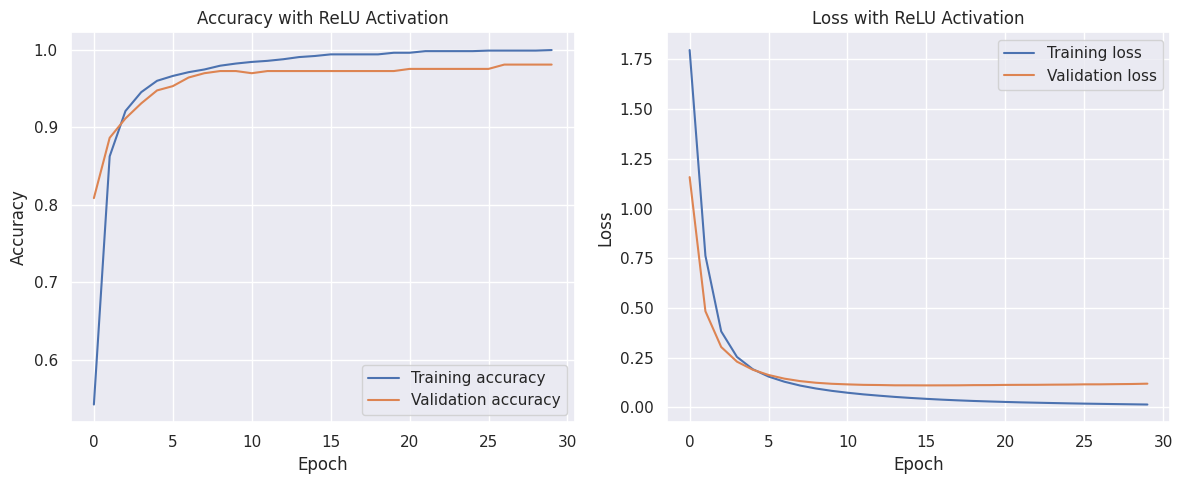

In [60]:
# Build a simple MLP model for digit classification
def build_digits_mlp(activation='relu'):
    """
    Build a basic MLP model for classifying digits

    Parameters:
    activation (str): Activation function to use in hidden layers

    Returns:
    keras.Model: Compiled Keras model
    """
    model = keras.Sequential([
        # Input layer accepts the flattened 8x8 images (64 features)
        layers.Input(shape=(64,)),

        # Hidden layers
        layers.Dense(128, activation=activation),
        layers.Dense(64, activation=activation),

        # Output layer with 10 units (one per digit) and softmax activation
        layers.Dense(10, activation='softmax')
    ])

    # Compile model with categorical crossentropy (standard for classification)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create MLP model with ReLU activation
digits_mlp_relu = build_digits_mlp(activation='relu')

# Display model summary
digits_mlp_relu.summary()

# Train the model
history_digits_relu = digits_mlp_relu.fit(
    X_digits_train, y_digits_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_digits_test, y_digits_test),
    verbose=1
)

# Evaluate the model
digits_relu_loss, digits_relu_acc = digits_mlp_relu.evaluate(X_digits_test, y_digits_test)
print(f"Test accuracy with ReLU: {digits_relu_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_digits_relu.history['accuracy'], label='Training accuracy')
plt.plot(history_digits_relu.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy with ReLU Activation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_digits_relu.history['loss'], label='Training loss')
plt.plot(history_digits_relu.history['val_loss'], label='Validation loss')
plt.title('Loss with ReLU Activation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

### Step 4: Implement the digits classification model in PyTorch

Epoch [1/30], Loss: 2.1212, Test Acc: 0.7583
Epoch [2/30], Loss: 1.2153, Test Acc: 0.8833
Epoch [3/30], Loss: 0.5568, Test Acc: 0.9083
Epoch [4/30], Loss: 0.3570, Test Acc: 0.9417
Epoch [5/30], Loss: 0.2603, Test Acc: 0.9389
Epoch [6/30], Loss: 0.2066, Test Acc: 0.9417
Epoch [7/30], Loss: 0.1680, Test Acc: 0.9333
Epoch [8/30], Loss: 0.1523, Test Acc: 0.9500
Epoch [9/30], Loss: 0.1256, Test Acc: 0.9556
Epoch [10/30], Loss: 0.1107, Test Acc: 0.9583
Epoch [11/30], Loss: 0.1059, Test Acc: 0.9667
Epoch [12/30], Loss: 0.0951, Test Acc: 0.9639
Epoch [13/30], Loss: 0.0816, Test Acc: 0.9583
Epoch [14/30], Loss: 0.0798, Test Acc: 0.9722
Epoch [15/30], Loss: 0.0695, Test Acc: 0.9639
Epoch [16/30], Loss: 0.0639, Test Acc: 0.9694
Epoch [17/30], Loss: 0.0648, Test Acc: 0.9750
Epoch [18/30], Loss: 0.0532, Test Acc: 0.9639
Epoch [19/30], Loss: 0.0532, Test Acc: 0.9611
Epoch [20/30], Loss: 0.0470, Test Acc: 0.9667
Epoch [21/30], Loss: 0.0449, Test Acc: 0.9694
Epoch [22/30], Loss: 0.0399, Test Acc: 0.96

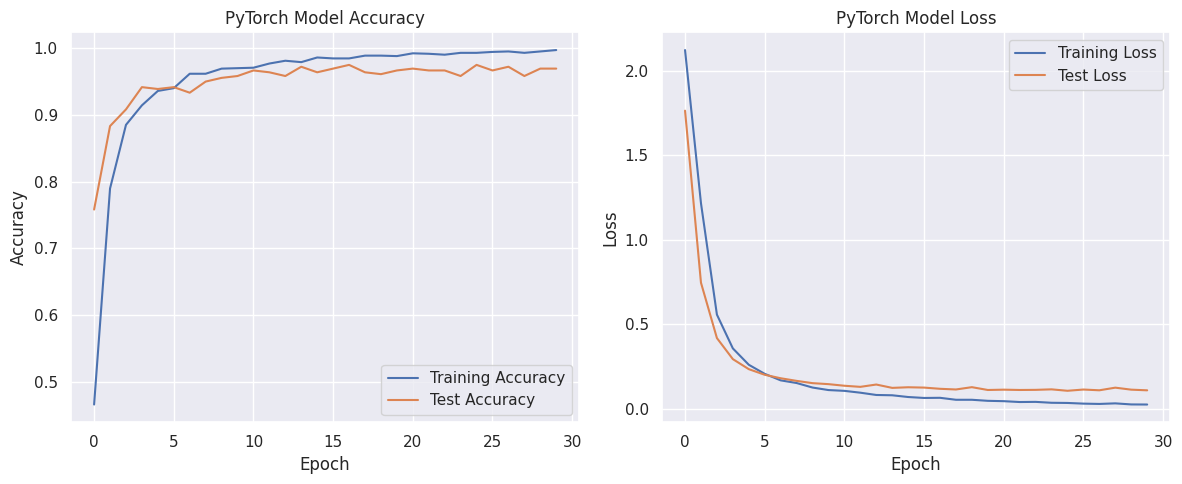

Final PyTorch model test accuracy: 0.9694


In [61]:
# Define a PyTorch MLP model for digits classification
class DigitsMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation_fn=nn.ReLU):
        """
        A basic MLP for digit classification

        Parameters:
        input_size (int): Number of input features (64 for digits)
        hidden_size1 (int): Size of first hidden layer
        hidden_size2 (int): Size of second hidden layer
        output_size (int): Number of output classes (10 for digits)
        activation_fn: PyTorch activation function class
        """
        super(DigitsMLP, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.activation1 = activation_fn()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.activation2 = activation_fn()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        # Forward pass through the network
        x = self.activation1(self.fc1(x))
        x = self.activation2(self.fc2(x))
        x = self.fc3(x)  # No activation here - we'll use CrossEntropyLoss which includes softmax
        return x

# Create a model with ReLU activations
input_size = X_digits_train.shape[1]  # 64 features
pytorch_digits_model = DigitsMLP(
    input_size=input_size,
    hidden_size1=128,
    hidden_size2=64,
    output_size=10,
    activation_fn=nn.ReLU
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pytorch_digits_model.parameters(), lr=0.001)

# Create DataLoader for batch training
train_dataset = TensorDataset(X_digits_train_tensor, y_digits_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 30
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    # Training phase
    pytorch_digits_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = pytorch_digits_model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Evaluation phase
    pytorch_digits_model.eval()
    with torch.no_grad():
        test_outputs = pytorch_digits_model(X_digits_test_tensor)
        test_loss = criterion(test_outputs, y_digits_test_tensor).item()
        test_losses.append(test_loss)

        _, predicted = torch.max(test_outputs.data, 1)
        test_acc = (predicted == y_digits_test_tensor).sum().item() / y_digits_test_tensor.size(0)
        test_accs.append(test_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Acc: {test_acc:.4f}')

# Plot the training and validation accuracy/loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('PyTorch Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('PyTorch Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Final PyTorch model test accuracy: {test_accs[-1]:.4f}")

### Step 5: Experiment with different activation functions (TensorFlow)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3388 - loss: 2.0211 - val_accuracy: 0.8361 - val_loss: 0.9659
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8688 - loss: 0.7932 - val_accuracy: 0.8889 - val_loss: 0.4875
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9233 - loss: 0.4330 - val_accuracy: 0.9222 - val_loss: 0.3236
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9448 - loss: 0.2992 - val_accuracy: 0.9444 - val_loss: 0.2457
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9548 - loss: 0.2308 - val_accuracy: 0.9528 - val_loss: 0.2028
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9631 - loss: 0.1890 - val_accuracy: 0.9583 - val_loss: 0.1775
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9664 - loss: 0.1603 - val_accuracy: 0.9556 - val_loss: 0.1618
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9679 - loss: 0.1392 - val_accuracy: 0.9639 - val_loss:

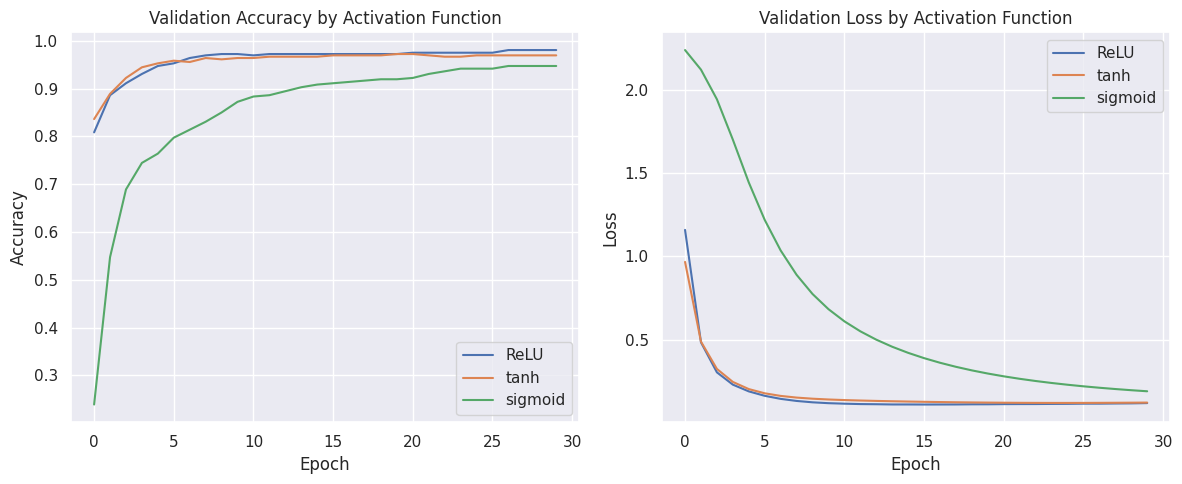

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


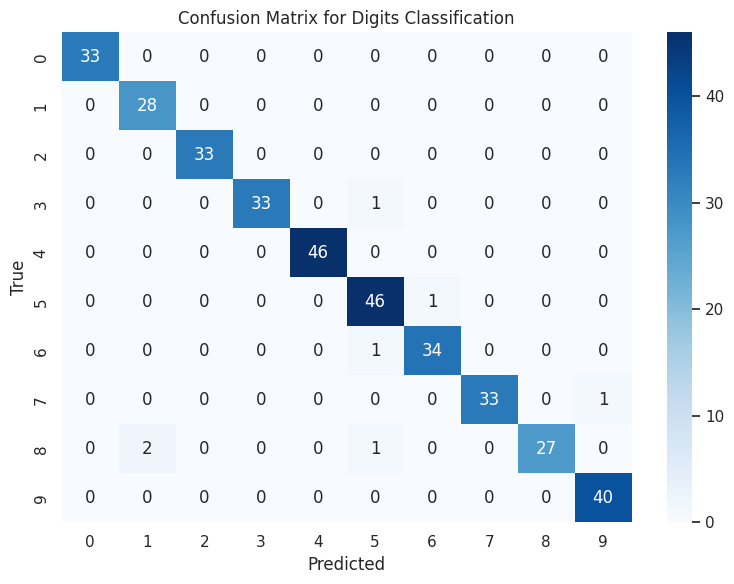

In [62]:
# Create and train a model with tanh activation
digits_mlp_tanh = build_digits_mlp(activation='tanh')

history_digits_tanh = digits_mlp_tanh.fit(
    X_digits_train, y_digits_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_digits_test, y_digits_test),
    verbose=1
)

# Create and train a model with sigmoid activation
digits_mlp_sigmoid = build_digits_mlp(activation='sigmoid')

history_digits_sigmoid = digits_mlp_sigmoid.fit(
    X_digits_train, y_digits_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_digits_test, y_digits_test),
    verbose=1
)

# Evaluate the models
_, digits_tanh_acc = digits_mlp_tanh.evaluate(X_digits_test, y_digits_test)
_, digits_sigmoid_acc = digits_mlp_sigmoid.evaluate(X_digits_test, y_digits_test)

print(f"Test accuracy with ReLU: {digits_relu_acc:.4f}")
print(f"Test accuracy with tanh: {digits_tanh_acc:.4f}")
print(f"Test accuracy with sigmoid: {digits_sigmoid_acc:.4f}")

# Compare validation accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_digits_relu.history['val_accuracy'], label='ReLU')
plt.plot(history_digits_tanh.history['val_accuracy'], label='tanh')
plt.plot(history_digits_sigmoid.history['val_accuracy'], label='sigmoid')
plt.title('Validation Accuracy by Activation Function')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_digits_relu.history['val_loss'], label='ReLU')
plt.plot(history_digits_tanh.history['val_loss'], label='tanh')
plt.plot(history_digits_sigmoid.history['val_loss'], label='sigmoid')
plt.title('Validation Loss by Activation Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Generate confusion matrix for best model (assuming ReLU is better)
y_pred_digits = np.argmax(digits_mlp_relu.predict(X_digits_test), axis=1)
cm = confusion_matrix(y_digits_test, y_pred_digits)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10),
            yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Digits Classification')
plt.tight_layout()
plt.show()